# Construction Clusters

In [1]:
from setup_tools import * # get all of the tools for the analyses

This is Text-Fabric 7.8.7
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

123 features found and 6 ignored
  0.00s loading features ...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used
  7.95s All features loaded/computed - for details use loadLog()


# Feature-Based Clustering in a Complex Constructional Network

After the analysis thus far, I believe I have gathered a list of features which are fairly efficacious at separating time constructions:

* PP | NP
* ה time
* H time H ___
    * \+ demonstrative
    * \+ ordinal
    * \+ attributive
* construct
    * construct + VP
    * construct + NP
* attributive (+אשר)
* pronominal suffix
* plural via du | pl endings
* quantification via quantNP

It is important that several of these features are "stackable"—meaning that they can be combined in different ways. The ultimate goal is to achieve a taxonomy of time constructions at the phrasal level. So how should we think about these various pieces and their inter-relatability?

One way to represent these structures would be with tree-like inheritance, so that a timePP inherits its NP patterns from timeNP. The limitations of this approach can be seen in the following construction:

* ב.ה.יום.ה.זה (e.g. Ex 19:1, Lev 8:34; 88x total) 
* ה.יום.ה.זה (e.g. Deut 2:25, 5:24; 29x total)

In a tree-based taxonomy, these two constructions would be separated into two different groups: PP phrases and NP phrases. This is problematic, because the taxonomy then misses the relatedness of the two phrases. Furthermore, the close relation could indeed be crucial to understanding the semantics of the NP version of this phrase: because ב.ה.יום.ה.זה is more common, hence more entrenched, it should inform how we read ה.יום.ה.זה. Indeed, this phrase seems to have very similar semantics to ב.ה.יום.ה.זה. In fact, the NP ה.יום.ה.זה would seem to have even less in common with other bare NP's, which typically do not indicate a point in time but a duration in time, e.g. שׁבעים שׁנים "for seven years."  

A better representation is a graph network, wherein constructions are represented as nodes and inheritances between them as edges. This format allows for multiple inheritance paths, and for numerous features to be modeled and compared at once. Furthermore, by utilizing the notion of a graph, it is possible to cluster based on a set-like comparison between features of constructions. For instance, in the case above: three similarities are registered, the presence of the *heh* definite article, the `H.time.H.modifier` construction, and the presence of the demonstrative. Thus, accounting for the difference of a preposition, we could place a value on this similarity, for instance, by saying they are 3/4 or 75% similar (the Jaccard similarity measure). These similarity values give the raw material needed to build clusters and taxonomic relations in a complex network. A nearest-neighbor clustering method (e.g. T-SNE) can find neighborhoods of similar constructions to identify distinct clusters within the constructions. A method such as PCA can be utilized to find major divisions and distinguish which features create the most separation in the dataset. The feature sets also allows us to easily select constructions based on the presence of a given feature. And we can look for associations and restrictions between particular features.

## Isolating a Test Set

I make one exclusion:

* exclude complex PP and NP constructions, i.e. those with coordination

Except for: 

* coordination in quantNP constructions is allowed

In [2]:
tagcount = collections.Counter()
tag2res = collections.defaultdict(list)
testset = set()

test = []

for cx in F.label.s('timephrase'):
    
    cx_words = L.d(cx, 'word')
    phrase = L.d(cx, 'phrase')[0]
    ph_words = L.d(phrase, 'word')
    
    time = Time(cx, api)
    
    # either there is no conj or quantNP
    is_quant = 'quant' in time.tag
    conj_check = ('conj' not in set(F.pdp.v(w) for w in cx_words)) or is_quant
    # either there is only 1 time or is quantNP
    ntime_check = (len([time.times]) < 2) or is_quant
    
    singlephrase = len(L.d(cx, 'phrase')) == 1
    pp_notin_np = not (F.typ.v(phrase) == 'NP' and 'prep' in set(F.pdp.v(w) for w in ph_words))
    nprep_check = [F.pdp.v(w) for w in cx_words].count('prep') < 2
    
    is_match = all([cx_words, conj_check, ntime_check, 
                    nprep_check, pp_notin_np, singlephrase])
    
    if is_match:
        tagcount[time.tag] += 1
        tag2res[time.tag].append(L.d(cx, 'phrase'))
        testset.add(cx)
        
tagcount = convert2pandas(tagcount)

print(tagcount.shape)

freq_times = len(F.label.s('timephrase'))

print('total time constructions: ', freq_times)
print('accounted for: ',  tagcount['Total'].sum(),' or ', tagcount['Total'].sum() / freq_times)

tagcount.head(20)

(96, 1)
total time constructions:  3881
accounted for:  3438  or  0.8858541612986344


,Total
time,617
PPtime,395
PPtime.H.attr_patt.demon,382
PPtime.H,267
time.H,222
PPtime.construct.cons+NP,194
time.pl.quant.card,175
PPtime.H.attr_patt.ord,150
time.quant.card,124
PPtime.construct.cons+VC,97


In [3]:
#A.show(tag2res['time.adju'], extraFeatures='sem_set')

In [4]:
# for tag in tagcount.index:
#     print(tag)
#     A.show(tag2res[tag][:1], extraFeatures='st')

Run the search...

In [5]:
tag2result = collections.defaultdict(list)
spec2result = collections.defaultdict(list)
cx2tag = {}
cx2preptags = {}
specdata = {}

for cx in testset:
    
    time = Time(cx, api)
    
    tag, result, features = time.tag, time.result, time.specs
    specdata[result[0]] = features # store on first cx node
    tag2result[tag].append(result)
    cx2tag[cx] = tag
    
    # build tags with prepositions
    phrase = L.d(cx, 'phrase')[0]
    if F.typ.v(phrase) == 'PP':
        prep = time.preps[0]
        prep_txt = ''.join(F.lex.v(w) for w in L.d(prep, 'word'))
        prep_tag = tag.replace('PPtime', prep_txt+'+time')
    else:
        prep_tag = 'ø+'+tag
    cx2preptags[cx] = prep_tag
    
    for spec in features:    
        spec2result[spec].append(result)
    
specdata = pd.DataFrame(specdata).fillna(0)
    
print(specdata.shape[0], 'results logged...')
print(len(tag2result.keys()), 'separate tags logged...')

19 results logged...
96 separate tags logged...


In [6]:
print(specdata.shape)
specdata.head()

(19, 3438)


,1449984,1449985,1449986,1449987,1449988,1449989,1449990,1449991,1449992,1449993,...,1449973,1449975,1449976,1449977,1449978,1449979,1449980,1449981,1449982,1449983
+VC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PPtime,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
adjv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
attr_patt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#A.show(tag2result['NP'], condenseType='sentence')

## Clustering with Fuzzy C-Means

C-means is a fuzzy clustering method which allows us to model both strong tendencies and ambiguity in the data. As with K-means, C-means requires a certain number of clusters to be predetermined. In order to find the ideal number of clusters, we can iterate from 2 to N and measure the partition coefficient for each iteration. The coefficient tells how compact the cluster is.

In [8]:
specdata.values.shape

(19, 3438)

In [9]:
part_coefficients = [] # partition coefficients
nclusters = [] # number of clusters

# measure coefficients for n-clusters 2 to 30
for i in range(2, 31): 
    cntr, u, u0, d, jm, p, fpc = cmeans(specdata.values, i, 2, error=0.005, maxiter=1000, seed=13)
    part_coefficients.append(fpc)
    nclusters.append(i)

Visualize the coefficient scores for each n-cluster. This helps us to see what the ideal number of clusters should be. We have to balance between "lumping and splitting" (as Croft calls it). With more clusters, we will inevitably have more consistency but with less usefulness. Thus we need to find the number of clusters that give the greatest consistency with the least amount of clusters.

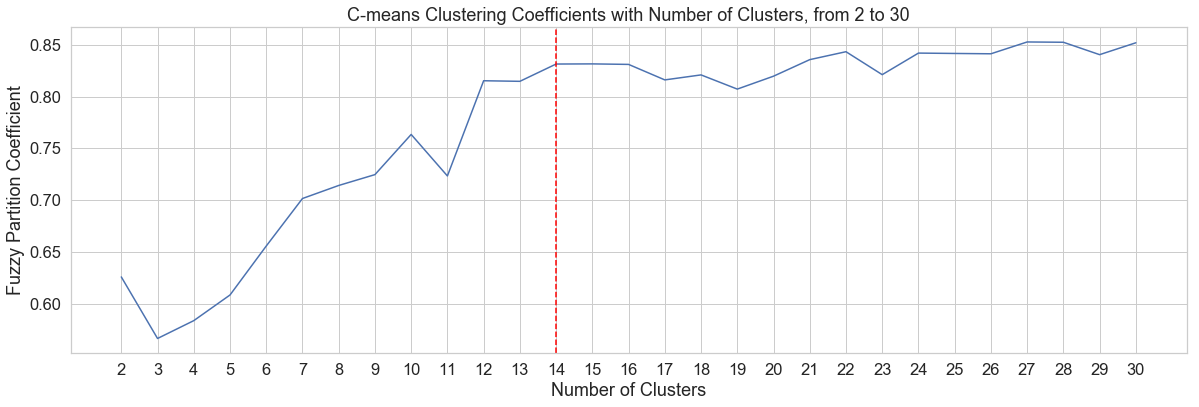

In [10]:
plt.figure(figsize=(20, 6))
plt.plot(nclusters, part_coefficients)
plt.xticks(nclusters)
plt.axvline(14, color='red', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Fuzzy Partition Coefficient')
plt.savefig(firstyear+'cmeans_clustering.png', dpi=300, bbox_inchex='tight')
plt.title(f'C-means Clustering Coefficients with Number of Clusters, from {nclusters[0]} to {nclusters[-1]}')
plt.show()

### Implement the Clusters

In [11]:
number_clusters = 14

cntr, u, u0, d, jm, p, fpc = cmeans(specdata.values, number_clusters, 2, error=0.005, maxiter=1000, seed=13)

In [12]:
u.shape

(14, 3438)

### Visualize Membership Coefficients within Clusters

Since these are fuzzy clusters, all clusters contain **all** the constructions. Each construction has a corresponding score, which tells how close it is to the mean within the cluster. This score helps us to visualize membership ambiguities.

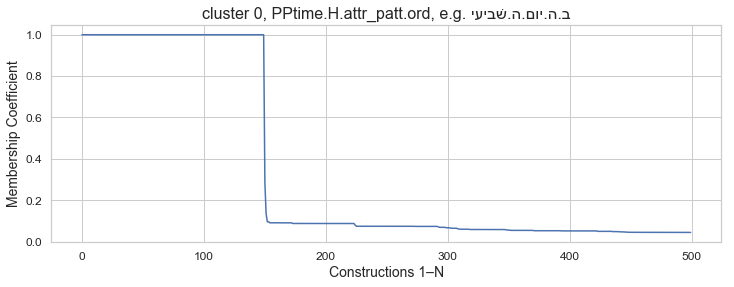

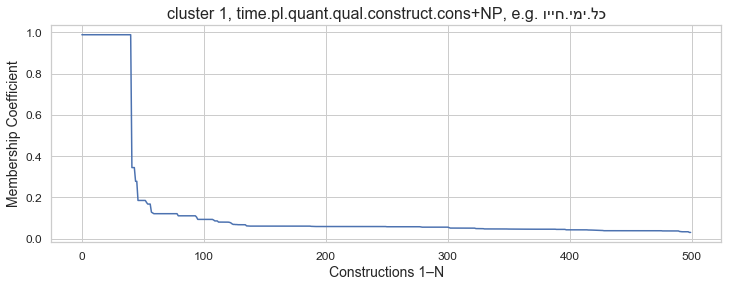

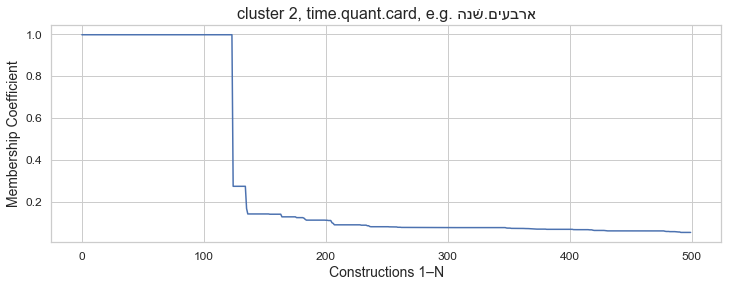

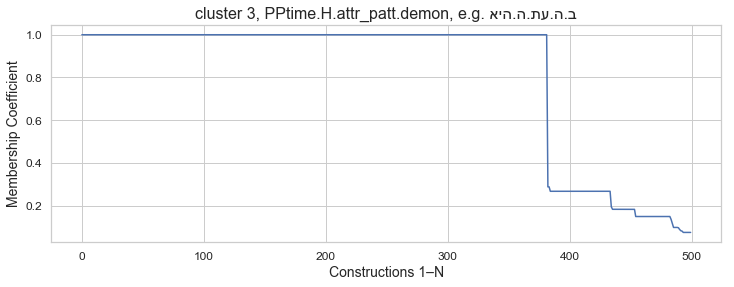

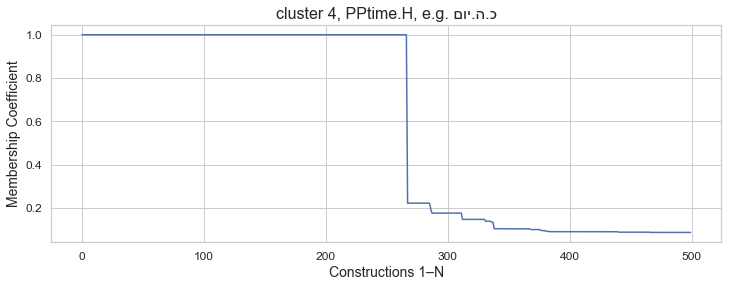

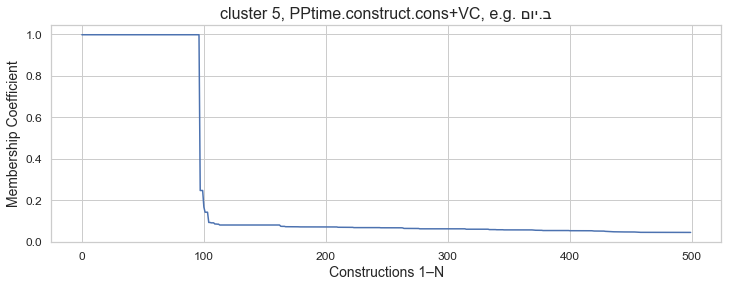

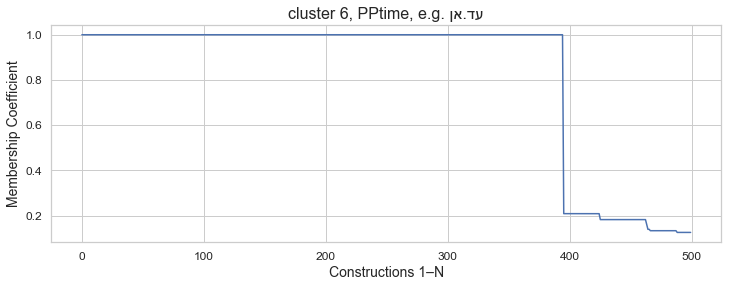

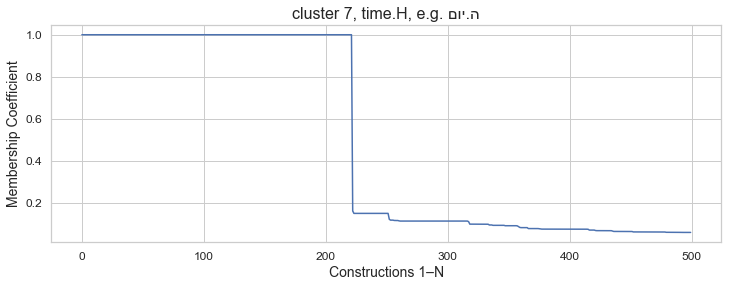

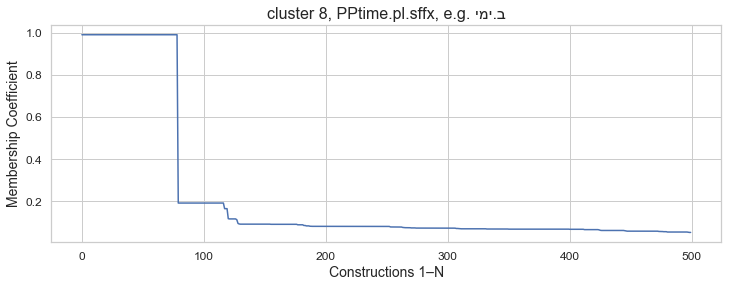

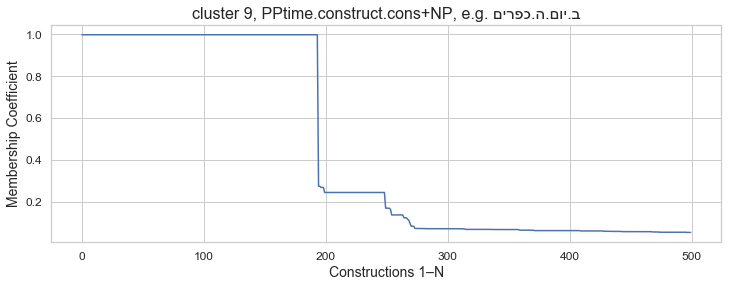

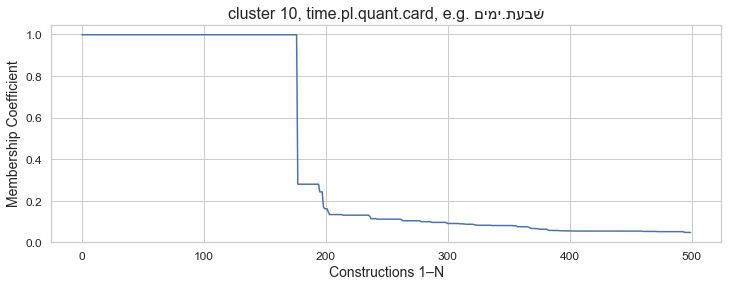

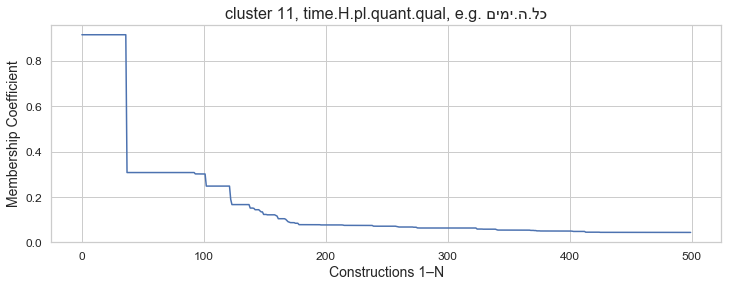

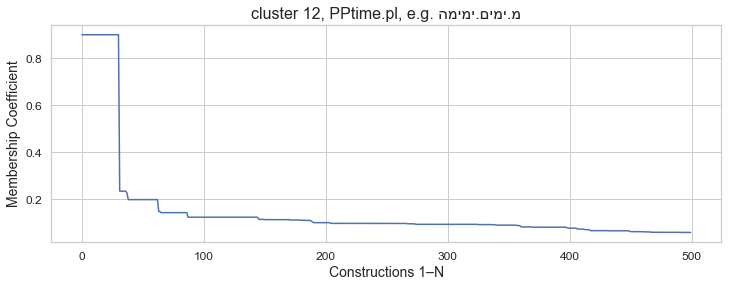

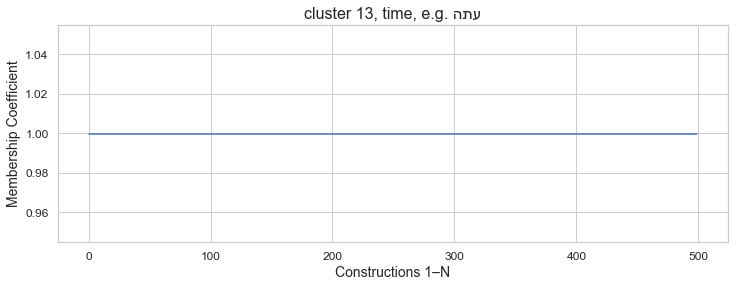

In [13]:
examplematrix = []

for i, cluster in enumerate(u):
    clustdata = pd.DataFrame(cluster, index=specdata.columns).sort_values(by=0, ascending=False)
    egcx = int(clustdata.index[0])
    eg = tokenize_surface(egcx, api)
    size = clustdata[clustdata[0] > 0.9].shape[0]
    
    examplematrix.append([cx2tag[egcx], eg, size])
    
    plt.figure(figsize=(12, 4))
    showdata = clustdata.values[:500]
    plt.plot(np.arange(showdata.shape[0]), showdata)
    plt.title(f'cluster {i}, {cx2tag[egcx]}, e.g. {reverse_hb(eg)}', size=16)
    plt.ylabel('Membership Coefficient', size=14)
    plt.xlabel('Constructions 1–N', size=14)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.show()

In [14]:
cluster_examples = pd.DataFrame(examplematrix, columns=['Cluster Name', 'Example', 'Size']).set_index('Cluster Name')
cluster_examples = cluster_examples.sort_values(by='Size', ascending=False)
cluster_examples

,Example,Size
Cluster Name,,
time,עתה,617
PPtime,עד.אן,395
PPtime.H.attr_patt.demon,ב.ה.עת.ה.היא,382
PPtime.H,כ.ה.יום,267
time.H,ה.יום,222
PPtime.construct.cons+NP,ב.יום.ה.כפרים,194
time.pl.quant.card,שׁבעת.ימים,177
PPtime.H.attr_patt.ord,ב.ה.יום.ה.שׁביעי,150
time.quant.card,ארבעים.שׁנה,124


In [15]:
cluster_examples['Size'].sum()

2813

In [16]:
cluster_examples.to_excel(firstyear+'clusters.xlsx')

### Count Good Fits and Find Misfits

Which constructions do not find themselves in an ideal cluster? First find the number of strong fits. All of these clusters have top scores far above the others. We can essentially describe an arbitrary cutoff point above ~0.2. We also store all of the cluster mappings. 

In [17]:
strong_fits = set()
clust2cx = {}
clust2mainlabel = {}
cx2clust = {}
clustermatrix = []

clustmainlabel2cx = collections.defaultdict(list)


for i, cluster in enumerate(u):
    clustdata = pd.DataFrame(cluster, index=specdata.columns)
    clustermatrix.append(clustdata[0].values)
    good_fits = clustdata[clustdata[0] > 0.9]
    mainlabel = cx2tag[clustdata.sort_values(ascending=False, by=0).index[0]]
    clust2mainlabel[i] = mainlabel
    
    for cx in good_fits.index:
        cx2clust[cx] = i
        strong_fits.add(cx)
        clustmainlabel2cx[mainlabel].append(cx)
    clust2cx[i] = set(good_fits.index)
    
    
label2clust = dict((label, clust) for clust, label in clust2mainlabel.items())
clustermatrix = pd.DataFrame(np.array(clustermatrix).T, columns=np.arange(number_clusters), index=specdata.columns)

print('number of time constructions', freq_times)
print('size of testset: ', len(testset))
print('number of strong fits:', len(strong_fits), '({}'.format(len(strong_fits) / freq_times), 'of all time constructions)')

number of time constructions 3881
size of testset:  3438
number of strong fits: 2813 (0.7248131924761659 of all time constructions)


#### Misfits

In [18]:
misfits = testset - strong_fits

print('number of misfits: ', len(misfits))

number of misfits:  625


In [19]:
# for i, mf in enumerate(list(misfits)[:100]):
    
#     closest = clustermatrix.loc[mf].sort_values(ascending=False)
#     clust, score = closest.index[0], closest.values[0]

#     print(f'closest to: {clust2mainlabel[clust]} ({clust}) with score of {score}')
    
#     print(cx2tag[mf])
#     A.prettyTuple(L.d(mf, 'phrase'), seq=i, condensed=False, extraFeatures='pdp')

This fact is readily explained in the constructional framework: a proto-typical adverb is placed into a noun construction and construed as such.

## Gather Paper Data

In [20]:
len(tag2result)

96

In [21]:
total_cx = freq_times

##### Number of +VC

In [22]:
# number of +VC specs

cons_VC = spec2result['cons+VC']
rela_VC = spec2result['rela+VC']
VC = spec2result['+VC']

tota_vc = len(cons_VC) + len(rela_VC) + len(VC)

tota_vc

153

In [23]:
tota_vc / total_cx

0.03942282916774027

In [24]:
#A.show(spec2result['+VC'])

In [25]:
formatPassages(cons_VC+rela_VC+VC, api)

'Gen 2:17, 5:1, 5:2, 6:4, 21:2, 21:8, 30:41, 31:10, 41:36; Exod 6:28, 10:28, 10:6, 40:37; Lev 5:24, 6:13, 7:16, 7:35, 7:36, 7:38, 13:14, 14:46, 23:12, 26:34, 26:35; Num 3:1, 3:13, 6:13, 6:6, 7:1, 7:10, 7:84, 8:17, 9:15, 30:13, 30:15, 30:6, 30:8, 30:9; Deut 4:15, 9:24, 16:6, 21:16, 27:2, 32:35; Josh 6:10, 9:12, 10:12, 10:27, 14:11; Judg 14:17, 18:30, 18:31; 1 Sam 1:28, 7:2, 8:8, 18:19, 20:31, 21:7, 22:4, 25:7, 27:11, 29:3, 29:6, 29:8; 2 Sam 13:32, 19:20, 19:25, 21:12, 22:1; 1 Kgs 2:37, 2:42, 2:8, 8:16, 9:10, 11:34, 17:14, 22:25; 2 Kgs 12:3; Isa 11:16, 14:3, 15:1, 30:26, 48:16; Jer 2:17, 6:15, 7:22, 11:14, 27:22, 29:10, 31:32, 34:13, 36:2, 38:28; Ezek 4:4, 4:9, 16:4, 16:5, 20:5, 24:25, 28:13, 31:15, 33:12, 39:13, 44:27; Amos 7:1; Obad 1:11, 1:12; Nah 2:4; Zech 8:23, 8:9; Mal 3:17, 3:21; Ps 18:1, 20:10, 32:6, 56:10, 56:4, 59:17, 90:15, 102:3, 105:19, 138:3; Job 6:17, 30:1; Ruth 1:1, 4:5; Song 8:8; Eccl 5:17, 8:15, 9:9; Lam 3:57; Esth 5:13; Dan 10:12, 12:11; Ezra 4:2; Neh 5:14, 13:15; 1 Ch

##### Cases of Bare Plurals

In [26]:
sorted(tag2result['time.pl'])

[(1447019, 665175, 21979),
 (1447452, 691104, 67687),
 (1448643, 756655, 182337),
 (1448730, 761025, 190127),
 (1449179, 789947, 235923),
 (1449716, 836622, 312440),
 (1449801, 842294, 320411),
 (1450128, 872379, 363163),
 (1450238, 880647, 377108),
 (1450244, 880989, 377616),
 (1450298, 883723, 383503),
 (1450502, 895610, 408992)]

In [27]:
len(tag2result['time.pl'])

12

In [29]:
formatPassages(tag2result['time.pl'], api)

'Gen 40:4; Lev 25:29; 1 Kgs 8:13, 17:15; Jer 2:32; Ps 16:7, 61:5; Eccl 11:8; Dan 11:33, 11:8; Neh 1:4; 2 Chr 6:2'

##### Time + cnstr + NP

In [30]:
len(spec2result['cons+NP'])

317

In [32]:
len(spec2result['cons+NP']) / len(list(F.label.s('timephrase')))

0.08167997938675599

In [33]:
sorted(spec2result['cons+NP'])[:10]

[(1446806, 652298, 1326),
 (1446807, 652380, 1454),
 (1446808, 652427, 1528),
 (1446852, 653632, 3760),
 (1446856, 653753, 4016),
 (1446857, 653870, 4262),
 (1446939, 658967, 12591),
 (1446944, 659400, 13270),
 (1446945, 659434, 13315),
 (1446946, 659438, 13322)]

##### Adverbs

In [35]:
len(tag2result['time'])

617

In [36]:
len(tag2result['PPtime'])

395

In [37]:
len(tag2result['time']) + len(tag2result['PPtime'])

1012

In [39]:
(len(tag2result['time']) + len(tag2result['PPtime'])) / len(list(F.label.s('timephrase')))

0.26075753671734087

In [40]:
T.sectionFromNode(672200)

('Exodus', 9, 5)

In [41]:
T.text(L.u(672200, 'verse')[0])

'וַיָּ֥שֶׂם יְהוָ֖ה מֹועֵ֣ד לֵאמֹ֑ר מָחָ֗ר יַעֲשֶׂ֧ה יְהוָ֛ה הַדָּבָ֥ר הַזֶּ֖ה בָּאָֽרֶץ׃ '

##### Suffix

In [42]:
random.shuffle(spec2result['sffx'])

In [43]:
#A.show(spec2result['sffx'], condensed=False)

In [44]:
T.sectionFromNode(800626)

('Jeremiah', 35, 7)

In [45]:
T.text(L.u(800626, 'verse')[0])

'וּבַ֣יִת לֹֽא־תִבְנ֗וּ וְזֶ֤רַע לֹֽא־תִזְרָ֨עוּ֙ וְכֶ֣רֶם לֹֽא־תִטָּ֔עוּ וְלֹ֥א יִֽהְיֶ֖ה לָכֶ֑ם כִּ֠י בָּאֳהָלִ֤ים תֵּֽשְׁבוּ֙ כָּל־יְמֵיכֶ֔ם לְמַ֨עַן תִּֽחְי֜וּ יָמִ֤ים רַבִּים֙ עַל־פְּנֵ֣י הָאֲדָמָ֔ה אֲשֶׁ֥ר אַתֶּ֖ם גָּרִ֥ים שָֽׁם׃ '

In [46]:
len(spec2result['sffx']) / total_cx

0.03555784591600103

In [48]:
formatPassages(spec2result['sffx'], api)

'Gen 10:25, 27:10, 27:7, 30:30, 41:27, 41:3, 48:6, 50:16; Exod 10:14, 12:14, 12:17, 12:42, 18:2, 40:15; Lev 13:35, 18:18, 26:4; Num 28:11, 28:2, 28:26, 33:39; Deut 11:14, 22:19, 22:29, 24:15, 28:12, 31:27, 31:29, 34:7; Judg 10:3, 12:11, 12:13, 12:8, 16:30; 1 Sam 17:33, 24:22, 25:28; 2 Sam 18:18; 1 Kgs 1:6, 3:12, 3:13, 5:7, 7:24, 11:12, 15:14, 15:16, 15:32, 16:34, 18:12, 21:29; 2 Kgs 8:20, 12:3, 15:18, 18:5, 23:25, 23:29, 24:1; Isa 38:10, 38:15, 39:8, 47:12, 47:15, 60:22; Jer 2:24, 5:24, 5:31, 17:11, 22:30, 23:6, 35:7, 35:8; Ezek 12:25, 16:23, 22:30, 23:3, 23:8, 34:26, 44:26; Hos 2:11; Joel 1:2; Hab 1:5; Ps 1:3, 49:19, 72:7, 90:14, 102:25, 104:33, 116:2, 145:15, 146:2; Job 15:32, 21:21, 21:3, 29:22; Prov 28:23; Eccl 5:16, 7:17, 9:1; Dan 1:5, 8:23; Neh 3:16, 3:17, 3:18, 3:20, 3:21, 3:22, 3:23, 3:24, 3:25, 3:27, 3:29, 3:30, 3:31, 9:19; 1 Chr 1:19, 22:5, 22:9; 2 Chr 1:12, 11:16, 11:20, 13:23, 15:17, 18:7, 21:8, 24:15, 24:22, 29:19, 34:33'

In [49]:
#A.show(tag2result['PPtime.pl.sffx'])

In [50]:
T.sectionFromNode(654163 )

('Genesis', 10, 25)

In [51]:
T.text(L.u(654163, 'verse')[0])

'וּלְעֵ֥בֶר יֻלַּ֖ד שְׁנֵ֣י בָנִ֑ים שֵׁ֣ם הָֽאֶחָ֞ד פֶּ֗לֶג כִּ֤י בְיָמָיו֙ נִפְלְגָ֣ה הָאָ֔רֶץ וְשֵׁ֥ם אָחִ֖יו יָקְטָֽן׃ '

##### Demonstrative

In [52]:
len(spec2result['demon'])

492

In [53]:
len(spec2result['demon']) / total_cx

0.12677145065704715

##### Definite Article Standalone

In [54]:
len(tag2result['time.H'])

222

In [55]:
len(tag2result['time.H']) / total_cx

0.05720175212574079

##### Attributive Construction

In [56]:
len(spec2result['attr_patt'])

643

In [57]:
len(spec2result['attr_patt']) / total_cx

0.16567894872455552

##### Attributed Example

In [58]:
A.show(tag2result['PPtime.attr_patt'])

In [59]:
[t for t in tag2result.keys() if 'attr_patt' in t]

['time.H.pl.attr_patt.adjv',
 'PPtime.H.pl.attr_patt.demon',
 'PPtime.H.attr_patt.ord',
 'time.H.attr_patt.demon',
 'PPtime.H.attr_patt.demon',
 'PPtime.H.attr_patt.ord.rela+VC',
 'PPtime.H.attr_patt.demon.rela+VC',
 'PPtime.H.pl.attr_patt.demon.rela+VC',
 'PPtime.H.quant.qual.attr_patt.demon',
 'PPtime.H.pl.quant.qual.attr_patt',
 'time.H.quant.qual.attr_patt.demon',
 'time.H.quant.qual.attr_patt.demon.construct.cons+NP',
 'time.H.attr_patt.adjv',
 'time.H.pl.attr_patt.demon',
 'PPtime.H.attr_patt.adjv',
 'PPtime.attr_patt']

In [60]:
A.show(tag2result['time.H.pl.attr_patt.adjv'])

In [61]:
T.sectionFromNode(870275)

('Ecclesiastes', 2, 16)

In [62]:
T.text(L.u( 870275, 'verse')[0])

'כִּי֩ אֵ֨ין זִכְרֹ֧ון לֶחָכָ֛ם עִֽם־הַכְּסִ֖יל לְעֹולָ֑ם בְּשֶׁכְּבָ֞ר הַיָּמִ֤ים הַבָּאִים֙ הַכֹּ֣ל נִשְׁכָּ֔ח וְאֵ֛יךְ יָמ֥וּת הֶחָכָ֖ם עִֽם־הַכְּסִֽיל׃ '

In [63]:
A.show(tag2result['time.H.attr_patt.adjv'])

##### Ordinals

In [64]:
len(spec2result['ord'])

154

In [65]:
len(spec2result['ord']) / total_cx

0.03968049471785622

### How many cases of demonstrative ה are found in discourse?

In [66]:
textype = collections.Counter()

for res in tag2result['PPtime.H']+tag2result['time.H']:
    cx = res[0]
    clause = L.u(cx, 'clause')[0]
    
    txt = F.txt.v(clause)
    txt = 'S' if {'Q', 'D'} & set(txt) else txt
        
    textype[txt] += 1
    
textype

Counter({'?': 4, 'S': 372, '??': 3, '?N': 15, 'N': 95})

In [67]:
d = 380
n = 95 + 15 + 4 + 3

d / (d+n)

0.7645875251509054

## Associations Between Prepositions and  Specifications

I have a hypothesis that the ל preposition may be attracted to plural endings, and that the concept of duration or distance may be crucial for understanding the difference between ל and a marker such as ב, which tends to indicate points in time rather than spans. It it difficult to know whether there will be any statistically significant attractions, given that  ְל can occur with durative terms that do not need the plural to become a duration (especially prototypical adverbs such as עולם). Thus I may try this analysis in a couple of steps. The first will look at all of the data, adverbial words included. Then I want to see if any associations are brought out by looking only at terms which *regularly* accept nominal endings. This can be a bit tricky, since even עולם *can* take nominal endings, as we saw in the tagging study of `prep.time` patterns above: 

### Preposition/øPreposition Associations Between Specifications

We can utilize the data processed in `specdata`, which contains both construction node ID's and the tagged features. 

This data is used to construct a co-occurrence matrix of feature x preposition. Non prepositional phrases are marked with null (øprep).

In [68]:
specdata.shape

(19, 3438)

In [69]:
specdata.head()

,1449984,1449985,1449986,1449987,1449988,1449989,1449990,1449991,1449992,1449993,...,1449973,1449975,1449976,1449977,1449978,1449979,1449980,1449981,1449982,1449983
+VC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PPtime,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
adjv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
attr_patt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# build co-occurrence data

specprep_counts = collections.defaultdict(lambda:collections.Counter())

for cx in specdata.columns:
    
    phrase = L.d(cx, 'phrase')[0]
    # get features but filter out PPtime and time since that's accounted for below
    features = dict((spec, count) for spec, count in specdata[cx].to_dict().items()
                       if spec not in {'PPtime', 'time'})
    
    # count tag and feature co-occurrences
    if F.typ.v(phrase) == 'PP':
        prep = E.head.t(phrase)[0]
        specprep_counts[F.lex_utf8.v(prep)].update(features)
    else:
        specprep_counts['ø'].update(features)
        
specprep_counts = pd.DataFrame(specprep_counts)

print(specprep_counts.shape)

specprep_counts.head()

(17, 12)


,ø,ל,עד,ב,אחר,מן,כ,בין,על,בלת,את,אל
+VC,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
H,367.0,48.0,148.0,690.0,18.0,9.0,31.0,7.0,0.0,1.0,1.0,0.0
adjv,36.0,8.0,1.0,25.0,1.0,14.0,16.0,0.0,1.0,0.0,0.0,0.0
attr_patt,37.0,4.0,83.0,494.0,13.0,4.0,8.0,0.0,0.0,0.0,0.0,0.0
card,339.0,13.0,1.0,28.0,2.0,24.0,2.0,1.0,0.0,0.0,1.0,0.0


In [71]:
specprep_counts.columns # target prepositions

Index(['ø', 'ל', 'עד', 'ב', 'אחר', 'מן', 'כ', 'בין', 'על', 'בלת', 'את', 'אל'], dtype='object')

In [72]:
specprep_counts.index # co-occurring features

Index(['+VC', 'H', 'adjv', 'attr_patt', 'card', 'cons+NP', 'cons+VC',
       'construct', 'demon', 'du', 'ord', 'pl', 'qual', 'quant', 'rela+NC',
       'rela+VC', 'sffx'],
      dtype='object')

Next, convert co-occurrence counts to Fisher's exact associations.

In [73]:
specprep_assocs = apply_fishers(specprep_counts)

specprep_assocs.head()

,ø,ל,עד,ב,אחר,מן,כ,בין,על,בלת,את,אל
+VC,-0.778882,0.000000,0.000000,0.748289,0.000000,0.787774,0.000000,0.000000,0.000000,0.000000,0.000000,-0.0
H,-12.685146,-0.282630,10.651763,10.004600,-4.259283,-12.437369,2.416897,0.332829,0.000000,0.643453,-0.000000,-0.0
adjv,-0.037472,1.194276,-2.020896,-4.503547,-0.428906,4.991358,12.144288,0.000000,1.285881,0.000000,0.000000,-0.0
attr_patt,-81.234259,-7.127963,8.348659,69.363570,-0.764466,-5.965193,-0.136874,-0.991563,0.000000,0.000000,0.000000,-0.0
card,88.202579,-0.292083,-11.378289,-68.082946,-3.182647,1.939361,-1.046006,0.000000,0.000000,0.000000,0.594375,-0.0


Show associations. **Any value greater than 1.3 is statistically associated,** since the p-values have been log10 transformed. **Any value less than -1.3 is significantly repelled.**

In [75]:
for prep in specprep_assocs:
    assocs = specprep_assocs[prep].sort_values(ascending=False)
    print(prep)
    print(assocs)
    print('\n', '-'*20, '\n')

ø
quant        131.014528
card          88.202579
qual          44.620932
pl            22.704880
rela+NC        2.204157
adjv          -0.037472
du            -0.135135
rela+VC       -0.397752
+VC           -0.778882
sffx          -9.623030
cons+VC      -10.156952
cons+NP      -11.575862
H            -12.685146
construct    -19.932980
ord          -30.509981
demon        -51.719571
attr_patt    -81.234259
Name: ø, dtype: float64

 -------------------- 

ל
pl           7.621296
cons+NP      3.842191
sffx         3.480876
construct    2.954643
rela+VC      1.209036
adjv         1.194276
cons+VC      0.000000
+VC          0.000000
du           0.000000
rela+NC      0.000000
H           -0.282630
card        -0.292083
ord         -1.490882
quant       -2.158314
qual        -3.133410
demon       -5.332474
attr_patt   -7.127963
Name: ל, dtype: float64

 -------------------- 

עד
demon        13.326935
H            10.651763
attr_patt     8.348659
cons+NP       0.443448
construct     0.31107

### Heatmap Visualization

In [76]:
speclabels = {'+VC': '+verbal_clause',
              'H': 'definite',
              'adjv': 'adjective',
              'attr_patt': 'attributive_pattern',
              'card': 'cardinal',
              'construct': 'construct',
              'cons+NP':'construct+NP',
              'cons+VC':'construct+VC',
              'demon':'demonstrative',
              'du':'dual suffix',
              'ord':'ordinal', 
              'pl':'plural', 
              'qual':'qualitative_quantifier',
              'quant':'quantifier', 
              'rela+NC': 'relative+NC', 
              'rela+VC': 'relative+VC',
              'sffx':'suffix'}

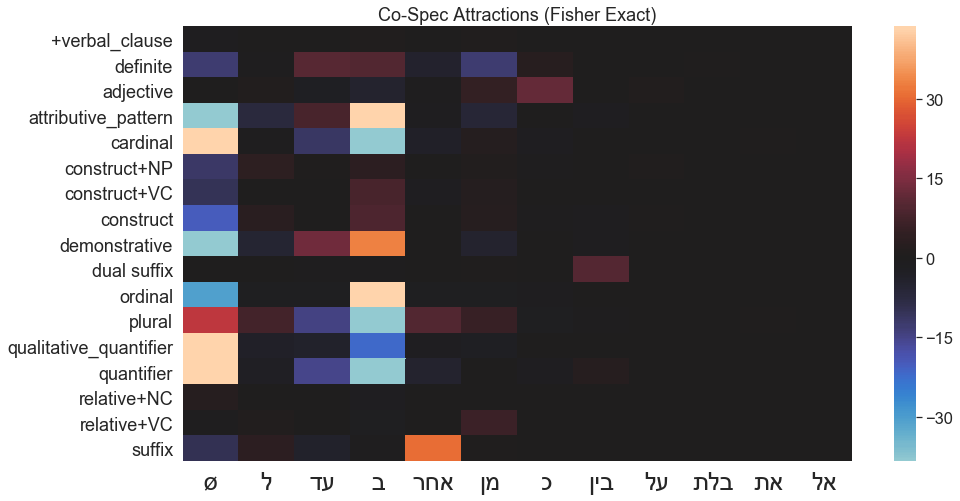

In [77]:
# make copy of data to add reversed Hebrew script
heatmap_specprep_assocs = specprep_assocs.copy()
heatmap_specprep_assocs.columns = [reverse_hb(spec) for spec in specprep_assocs.columns]
heatmap_specprep_assocs.index = [speclabels[spec] for spec in heatmap_specprep_assocs.index]
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_specprep_assocs, center=0, robust=True)
plt.xticks(size=25)
plt.yticks(size=18)
plt.savefig('../../data/paper_data/firstyear2/'+'spec_attractions.png', dpi=300, bbox_inches='tight')
plt.title('Co-Spec Attractions (Fisher Exact)')
plt.show()

### Clustering Prepositions with PCA

Plotting these prepositions with PCA can give a sense of how similar/dissimilar these prepositions are to one another, as well as inform us which factors most strogly influence their separation. We do that below.

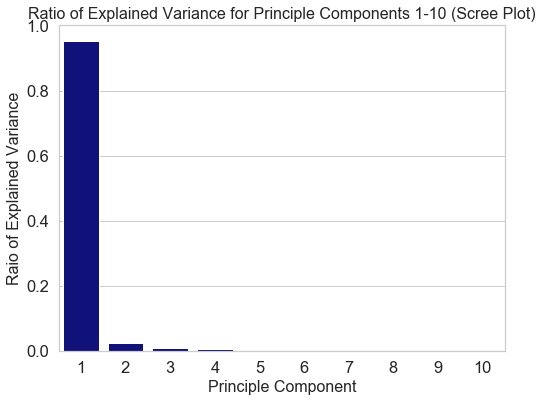

In [78]:
pca = PCA(10)
prep_fit = pca.fit(specprep_assocs.T.values)
pca_preps = prep_fit.transform(specprep_assocs.T.values)

preploadings = prep_fit.components_.T * np.sqrt(prep_fit.explained_variance_)
preploadings = pd.DataFrame(preploadings.T, index=np.arange(10)+1, columns=specprep_assocs.index)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=prep_fit.explained_variance_ratio_[:10], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=16)
plt.show()

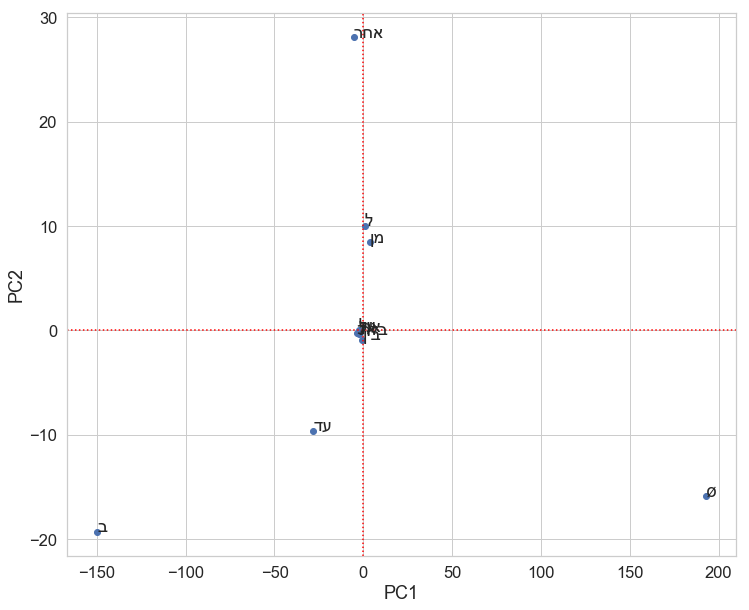

In [79]:
plot_PCA(specprep_assocs, components=(pca_preps[:,0], pca_preps[:,1]), annoTags=[reverse_hb(token) for token in specprep_assocs.columns])

#### Visualize the top influencing features

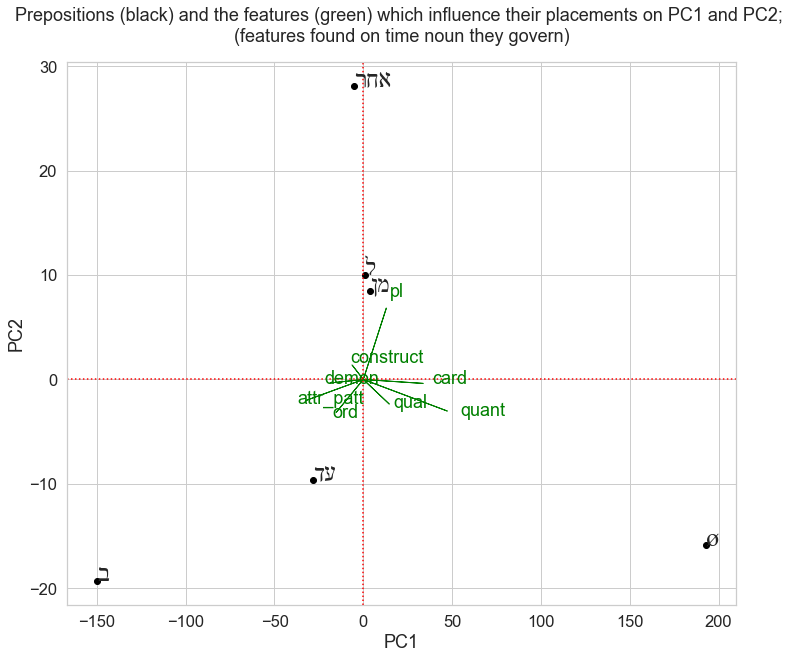

In [80]:
# filter x & y
x_filt = pd.DataFrame(pca_preps[:,0], index=specprep_assocs.columns)
y_filt = pd.DataFrame(pca_preps[:,1], index=specprep_assocs.columns)
x_filt = x_filt[specprep_counts.sum() > 100]
y_filt = y_filt[specprep_counts.sum() > 100]

# make simple x,y
x, y = x_filt.values, y_filt.values

influences = list(preploadings[:2].min().sort_values().head(4).index) + list(preploadings[:2].max().sort_values(ascending=False).head(4).index)

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

# annotate prepositions 
prep_xy = {} # for noun_dict
annoTags = x_filt.index
for i, prep in enumerate(annoTags):
    prep_x, prep_y = x[i], y[i]
    prep_xy[annoTags[i]] = (prep_x, prep_y)
    plt.annotate(reverse_hb(prep), xy=(prep_x, prep_y), size=26, fontname='Times New Roman')

# annotate loadings 
for feat in preploadings:
    if feat not in influences: # skip under-influencers
        continue
    x, y = preploadings[feat][:2]
    plt.arrow(0, 0, x, y, color='green')
    plt.annotate(feat, xy=(x*1.15, y*1.15), color='green', size=18)
    
plt.title('Prepositions (black) and the features (green) which influence their placements on PC1 and PC2; \n(features found on time noun they govern)', size=18, pad=20)
plt.show()

#### ל and בקר

ל seems to be associated with plurality. But it also occurs with terms like בקר "morning," which is a term that occurs 90+ times with ל's opposite: ב. Interestingly, the query below shows that 3 of 10 uses with בקר actually have "morning" in the plural! Could the singular uses represent a construal of a pointilliar time as a duration?

In [81]:
# A.show(A.search('''

# construction
#     phrase
#         =: word lex=L
#         <: word lex=H
#         <: word lex=BQR=/
# '''))

### Measuring Associations Between Specifiers

In [82]:
specdata.head()

,1449984,1449985,1449986,1449987,1449988,1449989,1449990,1449991,1449992,1449993,...,1449973,1449975,1449976,1449977,1449978,1449979,1449980,1449981,1449982,1449983
+VC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
PPtime,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
adjv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
attr_patt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
specicollocations = collections.defaultdict(lambda: collections.Counter())

for cx in specdata.columns:
    
    pos_values = specdata[cx][specdata[cx] > 0]
    
    for speci in pos_values.index:
        for specj in pos_values.index:
            if speci == specj:
                continue
            else:
                specicollocations[speci][specj] += 1
                
specicollocations = pd.DataFrame(specicollocations).fillna(0)

In [84]:
specicollocations = specicollocations.reindex(sorted(specicollocations.index), axis=1) # reorder index by sort

In [85]:
specicollocations.head()

,+VC,H,PPtime,adjv,attr_patt,card,cons+NP,cons+VC,construct,demon,du,ord,pl,qual,quant,rela+NC,rela+VC,sffx,time
+VC,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H,0.0,0.0,953.0,15.0,643.0,15.0,1.0,0.0,1.0,489.0,19.0,151.0,142.0,132.0,165.0,5.0,21.0,0.0,367.0
PPtime,5.0,953.0,0.0,66.0,606.0,72.0,258.0,100.0,359.0,454.0,25.0,154.0,297.0,54.0,151.0,0.0,27.0,121.0,0.0
adjv,0.0,15.0,66.0,0.0,3.0,52.0,2.0,0.0,2.0,0.0,5.0,0.0,32.0,0.0,57.0,0.0,0.0,0.0,36.0
attr_patt,0.0,643.0,606.0,3.0,0.0,0.0,1.0,0.0,1.0,488.0,0.0,151.0,55.0,23.0,23.0,0.0,5.0,0.0,37.0


In [86]:
specicollocations_assoc = apply_fishers(specicollocations)

In [87]:
# change identical pairwise comparison scores to 0
for speci in specicollocations_assoc.columns:
    for specj in specicollocations_assoc.index:
        if speci == specj:
            specicollocations_assoc[speci][specj] = 0

In [88]:
specicollocations_assoc = specicollocations_assoc.reindex(np.abs(specicollocations_assoc).mean().sort_values().index, axis=1) # reindex based on mean of absolute value on axis 1

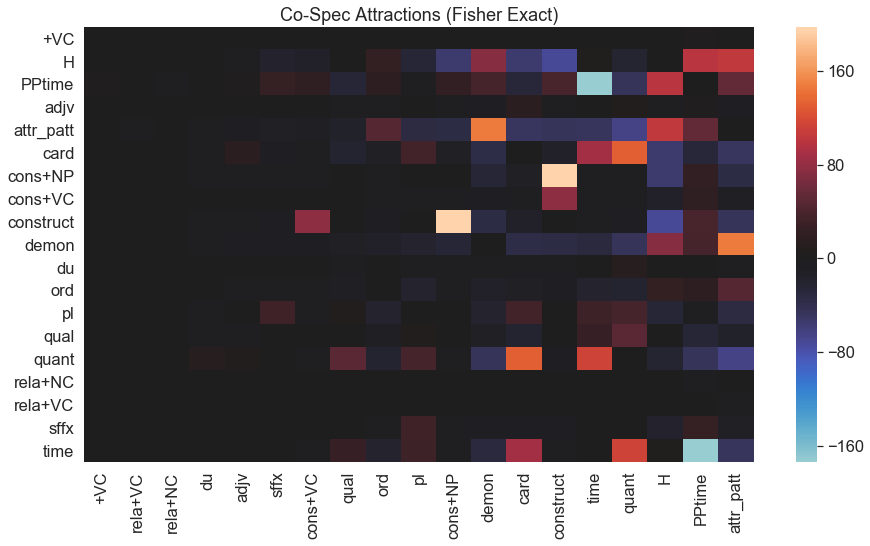

In [89]:
plt.figure(figsize=(15, 8))
plt.title('Co-Spec Attractions (Fisher Exact)')
sns.heatmap(specicollocations_assoc, center=1.3)
plt.show()

In [90]:
specicollocations_assoc['pl'].sort_values(ascending=False)

quant        37.238872
card         35.682028
sffx         32.828164
time         30.936220
qual          7.954322
cons+NP       2.501952
rela+NC       1.136004
construct     0.910022
adjv          0.865475
rela+VC       0.768443
+VC           0.000000
pl            0.000000
PPtime       -2.093860
cons+VC      -2.450576
du           -2.861936
ord         -19.381287
demon       -19.674136
H           -24.642764
attr_patt   -33.039559
Name: pl, dtype: float64

## Measuring In-Clause Constituent Order

Position from verb is represented as v+1 or v-1 etc.

**NB: Account for WJHJ...**

Count total number of time constructions in verbal clauses.

In [91]:
clause_kinds_raw = collections.Counter()

for cx in F.label.s('timephrase'):
    clause = L.u(cx, 'clause')[0]
    clause_kinds_raw[F.kind.v(clause)] += 1
    
convert2pandas(clause_kinds_raw)

,Total
VC,3275
WP,360
NC,246


In [92]:
clause_kinds = collections.Counter()
timeorders = collections.Counter()
pos2res = collections.defaultdict(list)
order2res = collections.defaultdict(list)
order2tense2res = collections.defaultdict(lambda: collections.defaultdict(list))
orderbytense = collections.defaultdict(lambda: collections.Counter())
posbytense = collections.defaultdict(lambda: collections.Counter())
wayehi_cases = []


for cx in testset:
    clause = L.u(cx, 'clause')[0]
    cl_kind = F.kind.v(clause)
    clause_kinds[cl_kind] += 1
    
    if cl_kind != 'VC':
        continue
        
    time_dat = Time(cx, api)
        
    time = L.u(time_dat.times[0], 'phrase')[0]

    # get the clause's primary predicate
    if F.typ.v(clause) in {'Ptcp'}:
        pred = next(ph for ph in L.d(clause, 'phrase') if F.function.v(ph) in {'PtcO', 'PreC'})
    else:
        pred = next(ph for ph in L.d(clause, 'phrase') if F.function.v(ph) in {'Pred', 'PreS', 'PreO'})

    # check for ויהי
    # get next clause if so
    order = None
    verb = next(w for w in L.d(pred, 'word') if F.pdp.v(w) == 'verb')
    vt, lex, ps, gn, nu = F.vt.v(verb), F.lex.v(verb), F.ps.v(verb), F.gn.v(verb), F.nu.v(verb)
    if all([vt in {'wayq', 'perf', 'weqt'}, lex == 'HJH[', ps == 'p3', gn == 'm', nu == 'sg']):
        try:
            clause_atom = L.d(clause, 'clause_atom')[0]
            next_clause = E.mother.t(clause_atom)[0]
            wayehi_cases.append([clause, L.d(cx, 'phrase')[0]])
            pred = next(ph for ph in L.d(clause, 'phrase') if F.function.v(ph) in {'Pred', 'PreS', 'PreO'})
            verb = next(w for w in L.d(pred, 'word') if F.pdp.v(w) == 'verb')        
            order = '-c'
        except:
            pass
        
    tense = F.vt.v(verb)    
    order = order or time-pred
    sign = '+' if type(order)==int and order > 0 else ''
    order_txt = f'{sign}{order}'
    timeorders[order_txt] += 1
    order2res[order_txt].append((cx, clause, time, pred))
    timepos = 'fronted' if order == '-c' or order < 0 else 'postverbal'

    pos2res[timepos].append((cx, clause, time, pred))
    orderbytense[order_txt][vt] += 1
    posbytense[timepos][vt] += 1
    order2tense2res[order_txt][vt].append((cx, clause, time, pred))

clause_kinds = convert2pandas(clause_kinds)
timeorders = convert2pandas(timeorders)
orderbytense = pd.DataFrame(orderbytense).fillna(0)
posbytense = pd.DataFrame(posbytense).fillna(0)

clause_kinds

,Total
VC,2880
WP,341
NC,217


In [93]:
len(wayehi_cases)

220

,Total
+2,743
-1,710
+1,567
+3,287
-c,220
-2,141
+4,96
-3,31
+5,29
-4,13


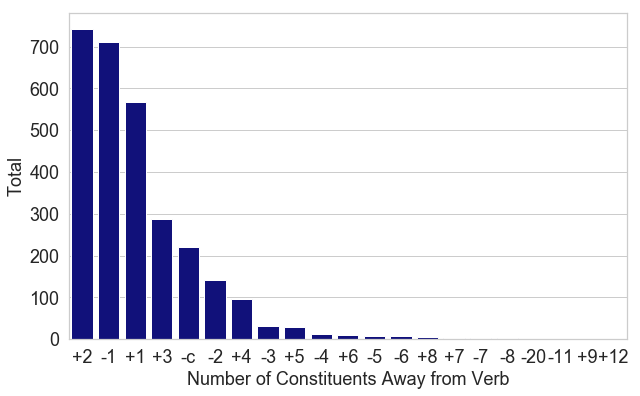

In [94]:
timeorders.to_excel(firstyear+'time_orders.xlsx')
display(timeorders.head(10))
countBarplot(timeorders, size=(10, 6), xlabel='Number of Constituents Away from Verb', save=firstyear+'timeposition.png')

Let's make a simpler distinction: pre-verbal or post-verbal...

In [95]:
pos_count = dict((pos, len(pos2res[pos])) for pos in pos2res)
pos_count = convert2pandas(pos_count)
pos_count['%'] = (pos_count / pos_count.sum()).round(2) * 100
pos_count.to_excel(firstyear+'pos_count.xlsx')
pos_count

,Total,%
postverbal,1743,61.0
fronted,1137,39.0


In [96]:
timeorders.loc[['+2', '-1', '+1', '-2']].sum() / pos_count['Total'].sum()

Total    0.750347
dtype: float64

In [97]:
#A.show(order2res[2], end=20)

### Looking at Order/Tense Associations

In [98]:
posbytense

,fronted,postverbal
impf,524,366
impv,14,67
infa,2,4
infc,2,107
perf,372,399
ptca,37,152
ptcp,4,9
wayq,155,482
weqt,27,157


In [99]:
pbt_assoc = apply_fishers(posbytense)

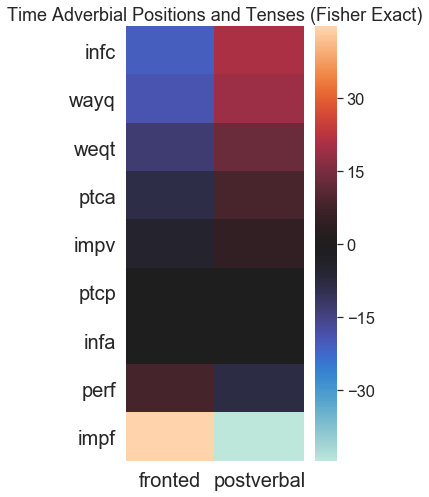

In [100]:
show_pbt_assoc = pbt_assoc.sort_values(by='fronted')

plt.figure(figsize=(4, 8))
sns.heatmap(show_pbt_assoc, center=0)
plt.yticks(size=20, rotation='horizontal')
plt.xticks(size=20)
plt.savefig(firstyear+'heatmap_timePOS.png', dpi=300, bbox_inches='tight')
plt.title('Time Adverbial Positions and Tenses (Fisher Exact)')
plt.show()

In [101]:
pcounts = posbytense[['postverbal', 'fronted']].sort_values(by='postverbal', ascending=False)
pcounts.to_excel(firstyear+'time_position.xlsx')
pcounts

,postverbal,fronted
wayq,482,155
perf,399,372
impf,366,524
weqt,157,27
ptca,152,37
infc,107,2
impv,67,14
ptcp,9,4
infa,4,2


## Verb Collocations 

### Method

This part of the analysis will seek to examine verb collocations against 3 reference points amongst time adverbials: direction, quantity, distance:

* direction - a preposition lexeme
* quantity - singular or plural (derived from pl, du, card, quant, qual)
* distance
    * near - e.g. ה, זה
    * far - e.g. היא, הוא
    
The end result will be a 3 part tag, with 9 possible combinations, e.g. **B.sg.near, L.pl.far**.

In order to build this data, we have to use a modified tagger function.

In [172]:
demon_maps = {'Z>T': 'near',
              'HJ>': 'far',
              'HMH': 'far',
              '>LH': 'near',
              'HM': 'far',
              'HW>': 'far',
              'ZH': 'near'}

cx2dqd = collections.defaultdict(set)
dqd2res = collections.defaultdict(list)
prettytags = {} # for converting from ugly transcription tags to pretty tags

for cx in specdata.columns:
    features = specdata[cx]
    phrase = L.d(cx, 'phrase')[0]
    
    # -- TAG DIRECTION --
    if F.typ.v(phrase) == 'PP':
        prep = next(w for w in L.d(phrase, 'word') if F.pdp.v(w)=='prep')
        direct = F.lex.v(prep)
        pretty_direct = reverse_hb(F.lex_utf8.v(prep))
    else:
        direct = 'ø'
        pretty_direct = 'ø'
        
    # -- TAG DISTANCE --
    # for standalone H demonstrative tests
    standalone = not any([features['demon'], features['attr_patt'],  # ensure no other modifiers
                          features['quant'], features['PPtime']])
    # check demonstratives
    if features['demon']:
        demon = next(w for w in L.d(cx, 'word') if F.pdp.v(w) in {'prde'})
        
        dist = demon_maps[F.lex.v(demon)]
    # check for demonstrative H
    elif features['H'] and standalone:
        dist = 'near'
        
    else:
        dist = 'ø'
        
    # -- TAG QUANTITY -- 
    plurals = any([features['quant'], features['pl'], features['du'], features['qual']])
    if plurals:
        quant = 'pl'
    else:
        quant = 'sg'
        
    # configure time for adverbs
    is_advb = not set(features[features>0].index) - {'time', 'PPtime'} # make sure nothing else is present
    head = 'TIME' if not is_advb else F.lex.v(E.nhead.t(phrase)[0])
    pretty_head = 'TIME' if not is_advb else reverse_hb(F.lex_utf8.v(E.nhead.t(phrase)[0]))
        
    # Direction, quantity, distance tag
    dqd = f'{direct}.{head}.{quant}.{dist}' # make usable tag
    
    # format pretty tag
    if pretty_head == 'TIME':
        dqd_pretty = f'{pretty_direct}.{pretty_head}.{quant}.{dist}'
    else:
        dqd_pretty = f'{pretty_head}.{pretty_direct}.{quant}.{dist}' # make pretty tag
    cx2dqd[cx] = dqd
    dqd2res[dqd].append((cx, phrase))
    prettytags[dqd] = dqd_pretty

In [108]:
dqd2res.keys()

dict_keys(['ø.<TH.sg.ø', 'L.TIME.pl.ø', 'L.CMC/.sg.ø', 'ø.>Z.sg.ø', '<D.TIME.pl.ø', 'ø.TIME.pl.ø', 'L.NYX/.sg.ø', 'B.TIME.sg.ø', '<D.>N.sg.ø', 'ø.>XR/.sg.ø', 'L.<D/.sg.ø', 'ø.>XRWN/.sg.ø', '>XR/.TIME.sg.ø', '>XR/.TIME.pl.ø', 'L.TIME.sg.ø', 'ø.TIME.sg.near', 'ø.LJLH/.sg.ø', 'B.TIME.pl.ø', '<D.MTJ.sg.ø', 'ø.MXR/.sg.ø', '<D.TIME.sg.ø', 'MN.<WLM/.sg.ø', 'ø.JWM/.sg.ø', 'L.<WLM/.sg.ø', 'B.LJLH/.sg.ø', 'K.TIME.pl.ø', 'ø.TIME.sg.ø', 'MN.TIME.pl.ø', 'B.TIME.pl.far', '>XR/.TIME.pl.near', 'L.TIME.sg.near', 'B.TIME.sg.near', 'B.TIME.sg.far', 'L.MXR/.sg.ø', 'MN.TIME.sg.ø', 'K.TIME.sg.ø', 'MN.<TH.sg.ø', '<D.<T/.sg.ø', '<D.TIME.sg.far', 'B.JWM/.sg.ø', '>XR/.KN.sg.ø', '<D.TIME.sg.near', '>XR/.Z>T.sg.ø', '<D.<WLM/.sg.ø', '<D.KN.sg.ø', 'MN.TIME.sg.far', 'BJN/.TIME.pl.ø', 'ø.RBJ<J/.sg.ø', 'ø.JWMM.sg.ø', '<L.TIME.sg.ø', '<D.HNH==.sg.ø', 'MN.MXRT/.sg.ø', 'ø.TMWL/.sg.ø', 'ø.TMJD/.sg.ø', 'K.TIME.sg.near', 'B.TIME.pl.near', 'L.<T/.sg.ø', 'B.<T/.sg.ø', '>XR/.ZH.sg.ø', 'MN.KN.sg.ø', 'L.<JLWM/.sg.ø', '<D.LJLH/.s

In [110]:
dqdbyevent = collections.defaultdict(lambda: collections.Counter())
dqdbytense = collections.defaultdict(lambda: collections.Counter())
dqd2event2res = collections.defaultdict(lambda: collections.defaultdict(list))
event2res = collections.defaultdict(list)
dqd2tense2res = collections.defaultdict(lambda: collections.defaultdict(list))
wayehi_cases = []
wayehi_exceptions = []

for cx in testset:
        tag = cx2dqd[cx]
        clause = L.u(cx, 'clause')[0]
        
        if F.kind.v(clause) != 'VC': # skip non-verbal clauses
            continue
            
        # get the clause's primary predicate
        if F.typ.v(clause) in {'Ptcp'}:
            pred = next(ph for ph in L.d(clause, 'phrase') if F.function.v(ph) in {'PtcO', 'PreC'})
        else:
            pred = next(ph for ph in L.d(clause, 'phrase') if F.function.v(ph) in {'Pred', 'PreS', 'PreO'})
            
        # check for ויהי
        # get next clause if so
        verb = next(w for w in L.d(pred, 'word') if F.pdp.v(w) == 'verb')
        vt, lex, ps, gn, nu = F.vt.v(verb), F.lex.v(verb), F.ps.v(verb), F.gn.v(verb), F.nu.v(verb)
        if all([vt in {'wayq', 'perf'}, lex == 'HJH[', ps == 'p3', gn == 'm', nu == 'sg']):
            try:
                clause_atom = L.d(clause, 'clause_atom')[0]
                next_clause = E.mother.t(clause_atom)[0]
                wayehi_cases.append([clause, L.d(cx, 'phrase')[0], next_clause])
                clause = L.u(next_clause, 'clause')[0]
                pred = next(ph for ph in L.d(clause, 'phrase') if F.function.v(ph) in {'Pred', 'PreS', 'PreO'})
                verb = next(w for w in L.d(pred, 'word') if F.pdp.v(w) == 'verb')
            except:
                wayehi_exceptions.append([L.d(cx, 'phrase')[0], next_clause])
                continue # skip them
            
            
        # check for obj/cmpl arguments
        obj_cmpl = set(ph for ph in L.d(clause,'phrase') if F.function.v(ph) in {'Objc', 'Cmpl'})
        sffx_obj = F.function.v(pred) in {'PtcO', 'PreO'}
        oc_check = '+obj/cmp' if any([obj_cmpl, sffx_obj]) else ''
        
        # tokenize the predicate
        vs, lex, vt = F.vs.v(verb), F.lex.v(verb), F.vt.v(verb)
        verb_token = f'{lex}.{vs}'
        
        # count co-occurrence
        result = (cx, clause, L.d(cx, 'phrase')[0],  verb)
        dqdbyevent[tag][verb_token] += 1
        dqdbytense[tag][vt] += 1
        dqd2event2res[tag][verb_token].append(result)
        dqd2tense2res[tag][vt].append(result)
        event2res[verb_token].append(result)
        
dqdbyevent = pd.DataFrame(dqdbyevent).fillna(0)
dqdbytense = pd.DataFrame(dqdbytense).fillna(0)

print(dqdbyevent.shape)
print(len(wayehi_cases), 'wayehi cases handled...')
print(len(wayehi_exceptions), 'wayehi exceptions ignored...')

dqdbyevent.head()

(611, 105)
193 wayehi cases handled...
36 wayehi exceptions ignored...


,ø.<TH.sg.ø,L.TIME.pl.ø,ø.>Z.sg.ø,<D.TIME.pl.ø,ø.TIME.pl.ø,L.NYX/.sg.ø,B.TIME.sg.ø,<D.>N.sg.ø,ø.>XR/.sg.ø,L.<D/.sg.ø,...,>XR/.MTJ.sg.ø,B.JWMM.sg.ø,>XR/.TIME.pl.far,ø.TIME.sg.far,MN.TIME.sg.near,ø.NYX/.sg.ø,<D.NYX/.sg.ø,ø.QDM/.sg.ø,B.FJBH/.sg.ø,<D.<RB/.sg.ø
<BD[.qal,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<BR[.hif,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<BR[.qal,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<CN[.qal,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<DH=[.hif,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
dqdbyevent.shape

(611, 105)

### Look at Raw Associations

In [112]:
dqdbyevent2 = dqdbyevent.drop('VM>[.qal') # remove outlier

In [113]:
dbe_assoc = apply_fishers(dqdbyevent2)
dbe_assoc.head()

,ø.<TH.sg.ø,L.TIME.pl.ø,ø.>Z.sg.ø,<D.TIME.pl.ø,ø.TIME.pl.ø,L.NYX/.sg.ø,B.TIME.sg.ø,<D.>N.sg.ø,ø.>XR/.sg.ø,L.<D/.sg.ø,...,>XR/.MTJ.sg.ø,B.JWMM.sg.ø,>XR/.TIME.pl.far,ø.TIME.sg.far,MN.TIME.sg.near,ø.NYX/.sg.ø,<D.NYX/.sg.ø,ø.QDM/.sg.ø,B.FJBH/.sg.ø,<D.<RB/.sg.ø
<BD[.qal,0.0,0.0,0.000000,0.0,11.380882,0.0,-1.644700,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<BR[.hif,0.0,0.0,0.000000,0.0,0.000000,0.0,0.761142,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<BR[.qal,0.0,0.0,0.000000,0.0,-0.305468,0.0,0.000000,0.0,0.812617,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<CN[.qal,0.0,0.0,1.366091,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<DH=[.hif,0.0,0.0,0.000000,0.0,0.000000,0.0,0.761142,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
dbe_assoc.max().sort_values(ascending=False).head(10)

ø.TIME.pl.ø        48.038077
>XR/.TIME.pl.ø     26.562123
ø.TIME.sg.near     20.135266
B.TIME.sg.ø        18.032513
<D.BQR=/.sg.ø       9.891457
MN.TIME.sg.ø        8.098747
<D.<WLM/.sg.ø       7.236799
<D.TIME.sg.near     7.037952
ø.LJLH/.sg.ø        6.790612
ø.MXR/.sg.ø         6.139996
dtype: float64

In [115]:
dbe_assoc.min().sort_values().head(10)

ø.TIME.pl.ø      -5.191690
B.TIME.sg.ø      -4.600029
ø.TIME.sg.near   -3.258922
B.TIME.sg.far    -3.025235
L.<WLM/.sg.ø     -1.314628
B.TIME.pl.ø      -1.309416
ø.>Z.sg.ø        -1.060734
ø.>XR/.sg.ø      -0.771584
<D.TIME.sg.ø     -0.768492
ø.<TH.sg.ø       -0.766386
dtype: float64

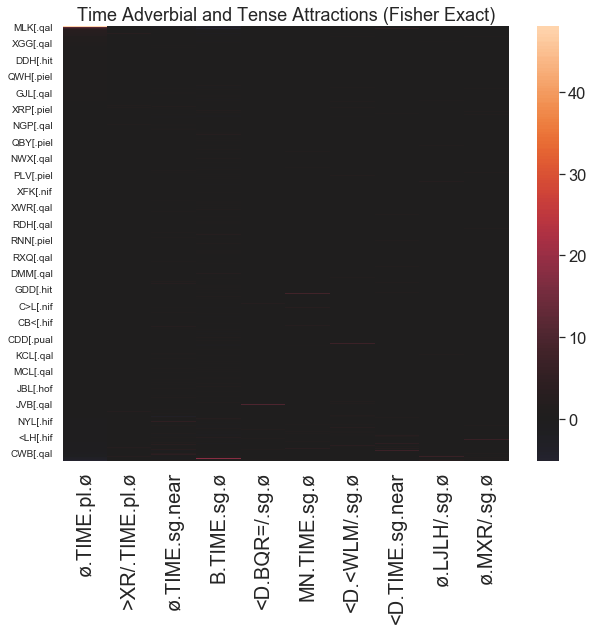

In [119]:
top_strongest = dbe_assoc.max().sort_values(ascending=False).head(10).index
compare = dbe_assoc[top_strongest].sort_values(by='ø.TIME.pl.ø', ascending=False)

#compare = compare.reindex(compare.T.quantile(0.25).sort_values().index).head(20) # get the most polarizing adverbials

plt.figure(figsize=(10, 8))
plt.title('Time Adverbial and Tense Attractions (Fisher Exact)')
sns.heatmap(compare, center=0)
plt.yticks(size=10)
plt.xticks(size=20, rotation='vertical')
plt.show()

### PCA Tests

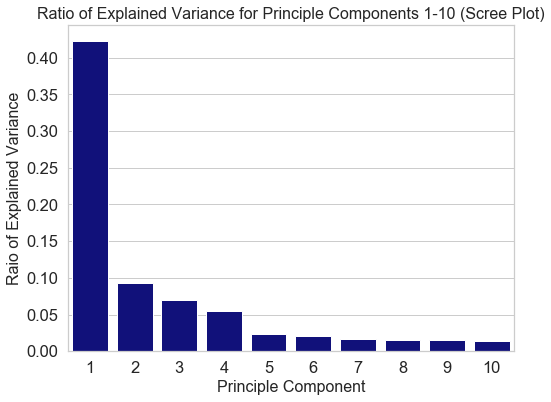

In [120]:
pca = PCA(10)
dqd_fit = pca.fit(dbe_assoc.T.values)
pca_dqd = dqd_fit.transform(dbe_assoc.T.values)

dqdloadings = dqd_fit.components_.T * np.sqrt(dqd_fit.explained_variance_)
dqdloadings = pd.DataFrame(dqdloadings.T, index=np.arange(10)+1, columns=dbe_assoc.index)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=dqd_fit.explained_variance_ratio_[:10], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=16)
plt.show()

In [121]:
def plot_PCA(pca_nouns, 
             zoom=tuple(), 
             noun_xy_dict=False, 
             save='', 
             annotate=True, 
             title='', 
             components=tuple(),
             annoTags=[],
             anno_size='18'
            ):
    '''
    Plots a PCA noun space.
    Function is useful for presenting various zooms on the data.
    '''
    
    x, y = components
    
    # plot coordinates
    plt.figure(figsize=(12, 10))
    plt.scatter(x, y, s=50)

    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    
    if title:
        plt.title(title, size=18)
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    plt.axhline(color='red', linestyle=':')
    plt.axvline(color='red', linestyle=':')
    
    # annotate points
    if annotate:
        noun_xy = {} # for noun_dict
        noun_lexs = annoTags
        
        for i, noun in enumerate(noun_lexs):
            noun_x, noun_y = x[i], y[i]
            noun_xy[annoTags[i]] = (noun_x, noun_y)
            if zoom: # to avoid annotating outside of field of view (makes plot small)
                if any([noun_x < xmin, noun_x > xmax, noun_y < ymin, noun_y > ymax]):                
                    continue # skip noun
            plt.annotate(noun, xy=(noun_x, noun_y), size=anno_size)
    
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    
    
    plt.show()
    
    if noun_xy_dict:
        return noun_xy

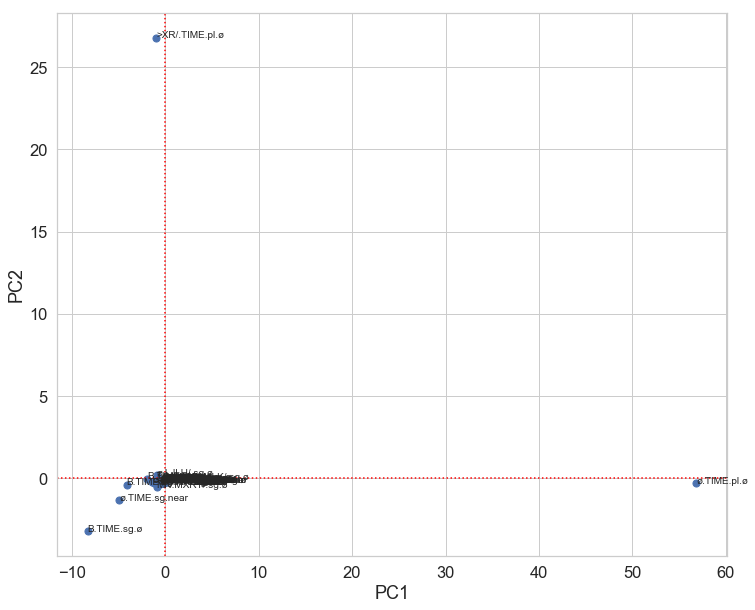

In [122]:
plot_PCA(dbe_assoc, components=(pca_dqd[:,0], pca_dqd[:,1]), annoTags=dbe_assoc.columns, anno_size=10)

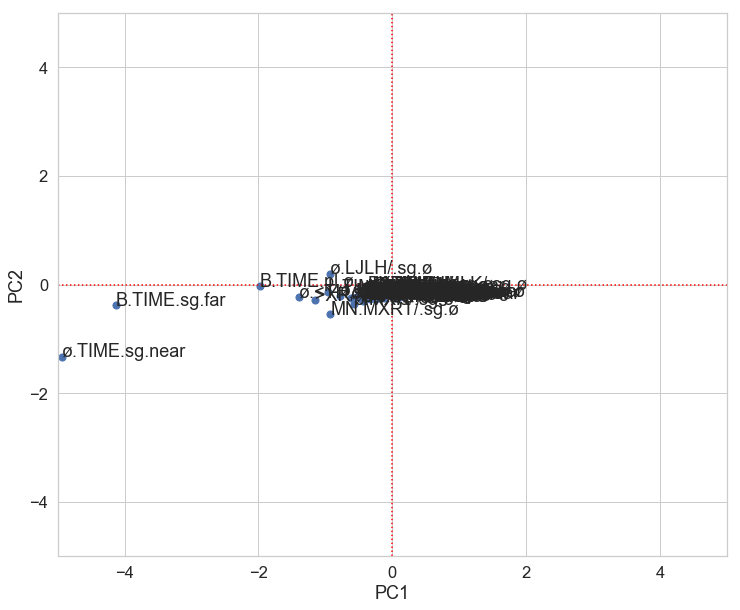

In [123]:
plot_PCA(dbe_assoc, zoom=(-5, 5, -5, 5), components=(pca_dqd[:,0], pca_dqd[:,1]), annoTags=dbe_assoc.columns)

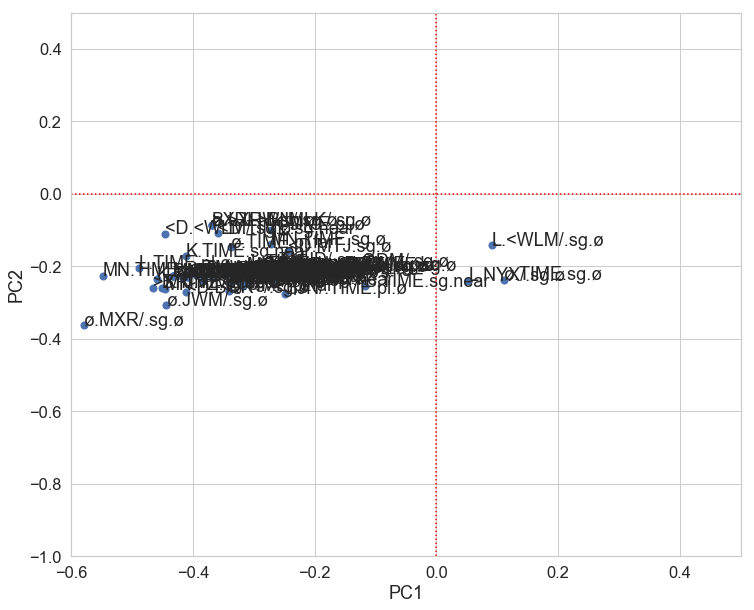

In [124]:
plot_PCA(dbe_assoc, zoom=(-0.6, 0.5, -1, 0.5), components=(pca_dqd[:,0], pca_dqd[:,1]), annoTags=dbe_assoc.columns)

In [125]:
# influences = list(dqdloadings[:2].min().sort_values().head(5).index) + list(dqdloadings[:2].max().sort_values(ascending=False).head(5).index)

# x, y = (pca_dqd[:,0], pca_dqd[:,1])

# # plot coordinates
# plt.figure(figsize=(12, 10))
# plt.scatter(x, y, color='black')
# plt.xlabel('PC1', size=18)
# plt.ylabel('PC2', size=18)
# plt.axhline(color='red', linestyle=':')
# plt.axvline(color='red', linestyle=':')

# zoom = (-10, 10, -7, 7)
# plt.xlim(zoom[0], zoom[1])
# plt.ylim(zoom[2], zoom[3])


# #plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
# plt.show()

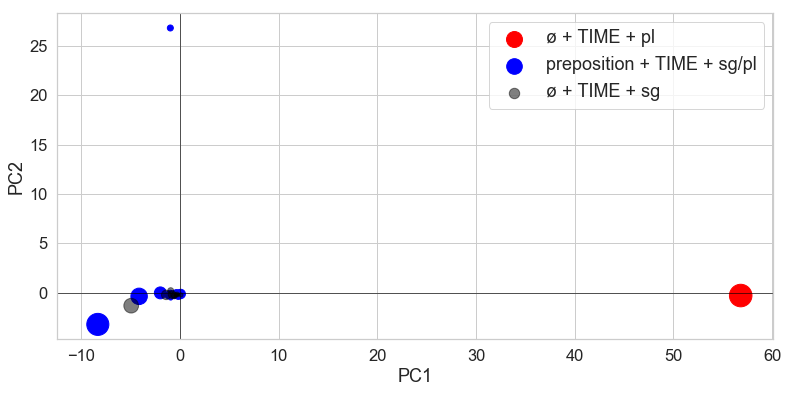

In [130]:
def show_dqd():
    x, y = pd.DataFrame(pca_dqd[:,0], index=dqdbyevent.columns), pd.DataFrame(pca_dqd[:,1], index=dqdbyevent.columns)
    xy = pd.concat([x, y], 1)
    xy.columns = ['x', 'y']

    axy = xy[xy.index.str.contains('pl') & xy.index.str.startswith('ø')] # red, ø+pl
    bxy = xy[xy.index.str.startswith('ø') & xy.index.str.contains('sg')] # +ø+sg
    cxy = xy.loc[[i for i in xy.index if i not in set(axy.index)|set(bxy.index)]] # +prep

    # plot coordinates
    plt.figure(figsize=(15, 6))
    
    ax1 = plt.scatter(axy['x'], axy['y'], s=dqdbyevent.sum()[axy.index], color='red')
    ax2 = plt.scatter(cxy['x'], cxy['y'], s=dqdbyevent.sum()[cxy.index], color='blue')
    ax3 = plt.scatter(bxy['x'], bxy['y'], s=dqdbyevent.sum()[bxy.index], color='black', alpha=0.5)
    
    plt.legend(['ø + TIME + pl', 'preposition + TIME + sg/pl', 'ø + TIME + sg'], loc='upper right', fontsize=18)

    plt.axhline(color='black', linewidth=0.6)
    plt.axvline(color='black', linewidth=0.6)
    
    plt.axis('scaled')
    
    zoom=False
    if zoom:
        xmin, xmax, ymin, ymax = zoom
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

    title = ''
    if title:
        plt.title(title, size=18)
    plt.xlabel('PC1', size=18)
    plt.ylabel('PC2', size=18)
    
# for lex in dqdloadings:
    
#     if lex not in influences:
#         continue
    
#     x, y = dqdloadings[lex][:2]
#     plt.arrow(0, 0, x, y, color='green')
    
#     # handle zooms
#     if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
#         continue
        
#     plt.annotate(lex, xy=(x*1.15, y*1.15), color = 'green', size=10)
    
    plt.savefig(firstyear+'aspect_pca.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
show_dqd()

In [131]:
pd.DataFrame(dqdloadings.loc[1].sort_values(ascending=False).head(30)).to_excel(firstyear+'durative_loadings.xlsx')
dqdloadings.loc[1].sort_values(ascending=False).head(30)

MLK[.qal     4.725406
XJH[.qal     2.300440
<BD[.qal     1.124547
JCB[.qal     0.690774
SGR[.hif     0.561958
JR>[.qal     0.322637
>BL[.hit     0.294521
HLK[.hif     0.287919
>KL[.qal     0.246131
CPV[.qal     0.236577
XNH[.qal     0.227140
LXY[.qal     0.215836
GWR[.qal     0.215836
CQV[.qal     0.188170
SWR[.qal     0.156724
HGH[.qal     0.143822
JYB[.hit     0.143822
JXL[.hif     0.143822
RPH[.hif     0.143822
YWR[.qal     0.143822
<FH[.nif     0.132468
HLK[.qal     0.121345
BKH[.qal     0.113508
SGR[.nif     0.102937
KPR[.piel    0.102876
NSH[.piel    0.102198
XGG[.qal     0.099873
RDP[.qal     0.097673
CKX[.nif     0.076295
YWM[.qal     0.075887
Name: 1, dtype: float64

In [132]:
dqdloadings.loc[1].sort_values().head(30)

BW>[.qal    -0.541729
CKM[.hif    -0.533074
YWH[.piel   -0.494078
JY>[.qal    -0.363752
>MR[.qal    -0.293375
DBR[.piel   -0.251903
QWM[.qal    -0.208093
JD<[.qal    -0.195784
MWT[.qal    -0.184928
LQX[.qal    -0.176717
NTN[.qal    -0.169137
CWB[.qal    -0.140308
XZQ[.hif    -0.127949
NKH[.hif    -0.116432
LJN[.qal    -0.113020
CM<[.qal    -0.097700
NGD[.hif    -0.091746
QR>[.qal    -0.089121
MY>[.qal    -0.086656
KLH[.piel   -0.082844
<LH[.qal    -0.082820
XLL[.hif    -0.082069
JRD[.qal    -0.075521
CLX[.qal    -0.073179
QWM[.hif    -0.072616
JY>[.hif    -0.072519
KWN[.hif    -0.072289
R>H[.qal    -0.070552
PC<[.qal    -0.064319
<NH[.qal    -0.063102
Name: 1, dtype: float64

### Surprising Cases

#### The Durative of Intent 

In [133]:
# A.show(event2res['SGR[.hif'])

In [134]:
T.sectionFromNode(686186)

('Leviticus', 13, 4)

In [135]:
T.text(L.u(686186, 'verse')[0])

'וְאִם־בַּהֶרֶת֩ לְבָנָ֨ה הִ֜וא בְּעֹ֣ור בְּשָׂרֹ֗ו וְעָמֹק֙ אֵין־מַרְאֶ֣הָ מִן־הָעֹ֔ור וּשְׂעָרָ֖ה לֹא־הָפַ֣ךְ לָבָ֑ן וְהִסְגִּ֧יר הַכֹּהֵ֛ן אֶת־הַנֶּ֖גַע שִׁבְעַ֥ת יָמִֽים׃ '

In [136]:
# A.show(dqd2event2res['ø.time.pl.ø']['>KL[.qal'])

In [137]:
T.sectionFromNode(652380)

('Genesis', 3, 14)

In [138]:
T.text(L.u(652380, 'verse')[0])

'וַיֹּאמֶר֩ יְהֹוָ֨ה אֱלֹהִ֥ים׀ אֶֽל־הַנָּחָשׁ֮ כִּ֣י עָשִׂ֣יתָ זֹּאת֒ אָר֤וּר אַתָּה֙ מִכָּל־הַבְּהֵמָ֔ה וּמִכֹּ֖ל חַיַּ֣ת הַשָּׂדֶ֑ה עַל־גְּחֹנְךָ֣ תֵלֵ֔ךְ וְעָפָ֥ר תֹּאכַ֖ל כָּל־יְמֵ֥י חַיֶּֽיךָ׃ '

### Identify Statistically Insignificant Cases

In [139]:
# surprises = collections.defaultdict(lambda:collections.defaultdict(list))

# for clust, events in clust2event2res.items():
#     for event in events:
        
#         results = clust2event2res[clust][event]
#         # check association score
#         assoc = cbe_assoc[clust][event]
#         if assoc < 0:
#             surprises[clust][event].extend(results)
            
# len(surprises)

In [140]:
# for key in surprises:
#     print(key, '\t', len(surprises[key]))

In [141]:
# for clust, events in surprises.items():
#     for event in events:
#         print(f'cluster: {clust}')
#         print(f'event: {event}')
#         print(f'assoc: {cbe_assoc[clust][event]}')
#         A.show(surprises[clust][event])
#         print('-'*20)

In [142]:
#dbe_assoc.loc['BW>[.qal+obj/cmp'].sort_values(ascending=False).head(10)

In [143]:
# dqdbyevent.loc['בוא.qal+obj/cmp'].sort_values(ascending=False)

In [144]:
# A.show(clust2event2res['time.pl.quant.card']['בוא.qal+obj/cmp'])

In [145]:
# cbe_assoc.loc['אמר.qal'].sort_values(ascending=False)

In [146]:
# A.show(clust2event2res['PPtime.pl']['אמר.qal'])

In [147]:
# A.show(clust2event2res['PPtime.H.pl.attr_patt.demon']['אמר.qal'])

### Durative & Verb Preferences

In [148]:
# cbe_assoc[duratives].max(1).sort_values(ascending=False)

In [149]:
# clusterbyevent[duratives].sum().sum()

### Tense Tests

In [150]:
dqdbytense

,ø.<TH.sg.ø,L.TIME.pl.ø,ø.>Z.sg.ø,<D.TIME.pl.ø,ø.TIME.pl.ø,L.NYX/.sg.ø,B.TIME.sg.ø,<D.>N.sg.ø,ø.>XR/.sg.ø,L.<D/.sg.ø,...,>XR/.MTJ.sg.ø,B.JWMM.sg.ø,>XR/.TIME.pl.far,ø.TIME.sg.far,MN.TIME.sg.near,ø.NYX/.sg.ø,<D.NYX/.sg.ø,ø.QDM/.sg.ø,B.FJBH/.sg.ø,<D.<RB/.sg.ø
impf,45.0,14.0,41.0,2.0,127.0,20.0,150,11.0,21.0,9.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
impv,3.0,3.0,0.0,0.0,9.0,0.0,21,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
infa,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
infc,0.0,2.0,0.0,0.0,26.0,0.0,42,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
perf,39.0,12.0,19.0,0.0,147.0,4.0,110,2.0,10.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ptca,1.0,4.0,1.0,0.0,15.0,0.0,28,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ptcp,2.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wayq,0.0,6.0,0.0,2.0,150.0,0.0,97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
weqt,0.0,2.0,0.0,0.0,34.0,0.0,35,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Examples for Paper

In [153]:
formatPassages(dqd2tense2res['ø.TIME.sg.near']['ptca'], api)

'Gen 41:9; Exod 13:4, 34:11; Deut 2:18, 4:40, 4:8, 5:1, 6:6, 7:11, 8:1, 8:11, 9:1, 10:13, 11:13, 11:26, 11:27, 11:28, 11:32, 11:8, 12:8, 13:19, 15:15, 15:5, 19:9, 26:16, 27:1, 27:10, 27:4, 28:1, 28:13, 28:14, 28:15, 29:11, 29:14, 29:17, 29:9, 30:11, 30:16, 30:2, 30:8, 31:21, 32:46; Josh 23:14; 1 Sam 19:11; 2 Sam 19:6, 19:7; 1 Kgs 8:28, 20:13; 2 Kgs 2:3, 2:5, 4:23; Jer 28:16; Zech 9:12; Ruth 3:2'

In [154]:
cbt_assoc = apply_fishers(dqdbytense)

### Look at Raw Associations

In [155]:
cbt_assoc.max().sort_values(ascending=False).head(10)

ø.TIME.sg.near     18.887285
MN.MXRT/.sg.ø      12.617700
B.TIME.sg.far      11.835884
<D.TIME.sg.near     9.179484
<D.TIME.sg.ø        9.152380
ø.>Z.sg.ø           7.905404
ø.TIME.pl.ø         7.640880
L.NYX/.sg.ø         6.588212
L.<WLM/.sg.ø        6.052017
>XR/.TIME.pl.ø      4.862489
dtype: float64

In [156]:
cbt_assoc.min().sort_values().head(10)

ø.<TH.sg.ø        -8.791190
ø.TIME.sg.near    -7.513755
<D.TIME.sg.near   -6.774742
L.<WLM/.sg.ø      -6.005682
ø.>Z.sg.ø         -5.696359
ø.TIME.pl.ø       -3.966758
B.TIME.sg.far     -3.466934
ø.LJLH/.sg.ø      -3.457521
B.TIME.pl.ø       -3.282739
ø.>XR/.sg.ø       -2.898310
dtype: float64

### PCA Tests

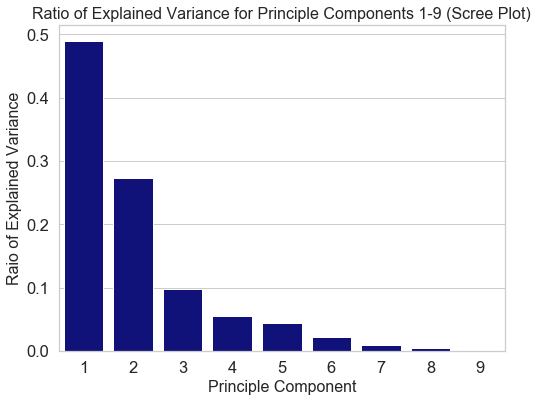

In [157]:
pca = PCA(9)
cbt_fit = pca.fit(cbt_assoc.T.values)
pca_cbt = cbt_fit.transform(cbt_assoc.T.values)

cbtloadings = cbt_fit.components_.T * np.sqrt(cbt_fit.explained_variance_)
cbtloadings = pd.DataFrame(cbtloadings.T, index=np.arange(9)+1, columns=cbt_assoc.index)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(9)+1, y=cbt_fit.explained_variance_ratio_[:9], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-9 (Scree Plot)', size=16)
plt.show()

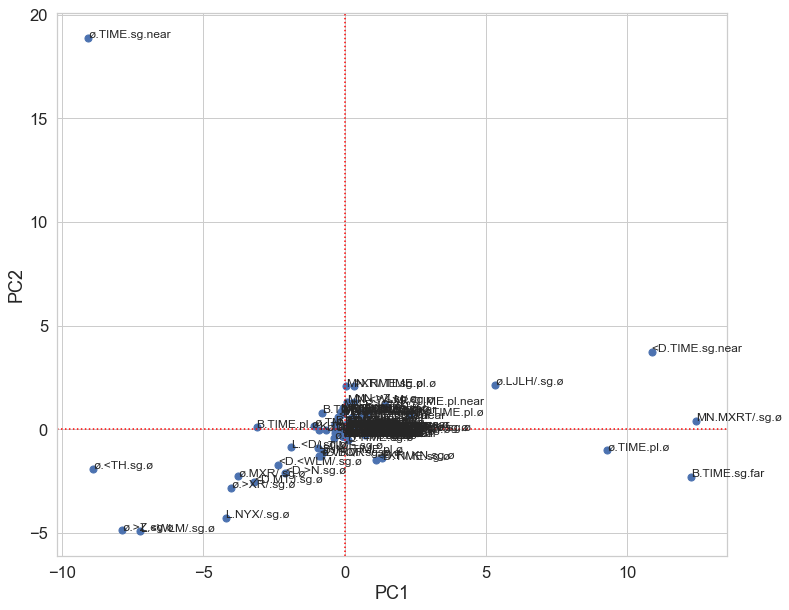

In [158]:
plot_PCA(cbt_assoc,  components=(pca_cbt[:,0], pca_cbt[:,1]), annoTags=cbt_assoc.columns, anno_size=12)

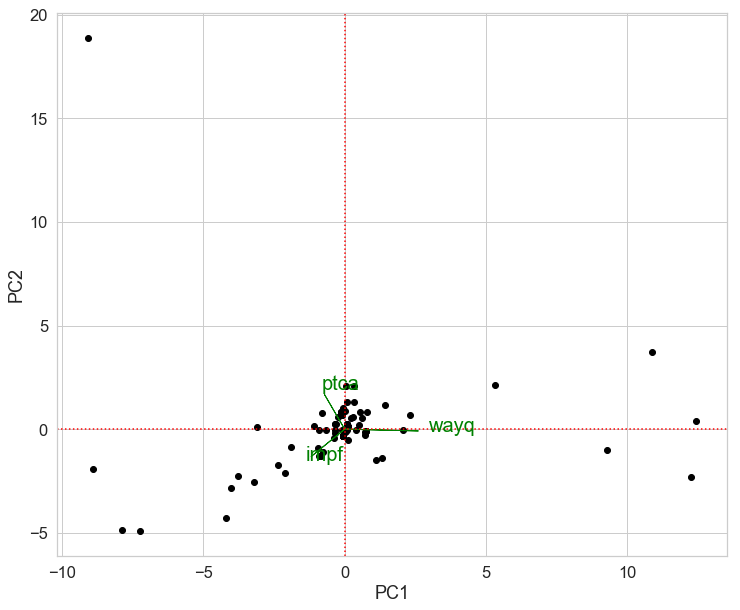

In [159]:
x, y = (pca_cbt[:,0], pca_cbt[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

for verbconj in ('wayq', 'ptca', 'impf'):
    x, y = cbtloadings[verbconj][:2]
    plt.arrow(0, 0, x, y, color='green')
    plt.annotate(verbconj, xy=(x*1.15, y*1.15), color = 'green', size=20)
        
plt.show()

### Exploring the Contribution of Prepositions

In [160]:
# def show_cbt(zoom=None):

#     x, y = pd.DataFrame(pca_cbt[:,0], index=dqdbyevent.columns), pd.DataFrame(pca_cbt[:,1], index=dqdbytense.columns)
#     xy = pd.concat([x, y],1)
#     xy.columns = ['x', 'y']

# #     axy = xy[xy.index.str.contains('sg')]
# #     bxy = xy[xy.index.str.contains('pl')]
# #     cxy = xy.loc[[i for i in xy.index if i not in set(axy.index)|set(bxy.index)]]

#     axy = xy[xy.index.str.startswith('MN')] # blue
#     bxy = pd.concat([xy[xy.index.str.startswith('<D')], xy[xy.index.str.startswith('L')]]) # red
#     dxy = xy.loc[[i for i in xy.index if i not in set(axy.index)|set(bxy.index)]] # grey

#     # plot coordinates
#     plt.figure(figsize=(12, 10))
#     plt.scatter(axy['x'], axy['y'], s=dqdbyevent.sum()[axy.index], color='blue')
#     plt.scatter(bxy['x'], bxy['y'], s=dqdbyevent.sum()[bxy.index], color='red')
#     plt.scatter(dxy['x'], dxy['y'], s=dqdbyevent.sum()[dxy.index], color='grey', alpha=0.5)

# #     mn = 'ןמ'
# #     lad = 'ל & דע'
# #     plt.legend([mn, lad], loc='lower left', fontsize=25)
    
#     if zoom:
#         xmin, xmax, ymin, ymax = zoom
#         plt.xlim(xmin, xmax)
#         plt.ylim(ymin, ymax)

#     title = ''
#     if title:
#         plt.title(title, size=18)
#     plt.xlabel('PC1', size=18)
#     plt.ylabel('PC2', size=18)
    
#     plt.axhline(color='red', linestyle=':')
#     plt.axvline(color='red', linestyle=':')

#     annotate = False
#     # annotate points
#     if annotate:
#         noun_xy = {} # for noun_dict
#         noun_lexs = annoTags

#         for i, noun in enumerate(noun_lexs):
#             noun_x, noun_y = x[i], y[i]
#             noun_xy[annoTags[i]] = (noun_x, noun_y)
#             if zoom: # to avoid annotating outside of field of view (makes plot small)
#                 if any([noun_x < xmin, noun_x > xmax, noun_y < ymin, noun_y > ymax]):                
#                     continue # skip noun
#             plt.annotate(noun, xy=(noun_x, noun_y), size=anno_size)
            
#     for verbconj in ('ptca', 'wayq', 'impf', 'perf'):
#         x, y = cbtloadings[verbconj][:2]
#         plt.arrow(0, 0, x, y, color='green')
#         plt.annotate(verbconj, xy=(x*1.15, y*1.15), color = 'green', size=16)
            
# #    plt.title('Opposition of ל & דע over against ןמ, based on their verb collocation preferences')
            
#     plt.show()

# show_cbt()

#### Looking at Loadings

In [161]:
cbtloadings.loc[1].sort_values(ascending=False)

wayq    2.606458
weqt    0.205999
infa   -0.043564
ptcp   -0.106547
infc   -0.109323
perf   -0.144076
impv   -0.268808
ptca   -0.713223
impf   -1.187288
Name: 1, dtype: float64

In [162]:
#A.show(clust2tense2res['time.H']['ptca'])

In [163]:
#A.show(clust2tense2res['time.pl.quant.card']['wayq'])

### Verb Collocations

In [167]:
pretty_tense = {'impf': 'yiqtol',
               'impv': 'imperative',
               'infa': 'infinitive_abs',
               'infc': 'infinitive_cons', 
               'perf': 'qatal', 
               'ptca': 'participle_act',
               'ptcp': 'participle_pass',
               'wayq': 'wayyiqtol', 
               'weqt': 'weqatal'}

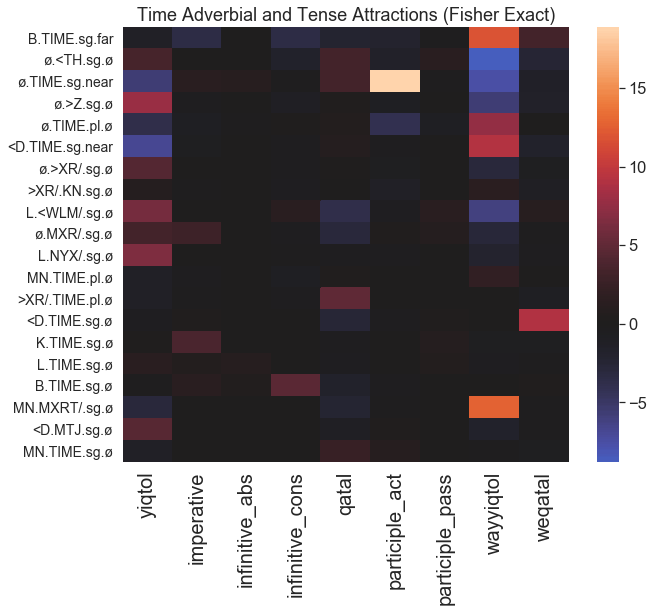

In [168]:
compare = cbt_assoc.T
compare = compare.reindex(compare.T.quantile(0.25).sort_values().index).head(20) # get the most polarizing adverbials
compare.columns = [pretty_tense[tense] for tense in compare.columns]

plt.figure(figsize=(10, 8))
sns.heatmap(compare, center=0)
plt.yticks(size=14)
plt.xticks(size=20, rotation='vertical')
plt.savefig(firstyear+'heatmap_tenses.png', dpi=300, bbox_inches='tight')
plt.title('Time Adverbial and Tense Attractions (Fisher Exact)')
plt.show()

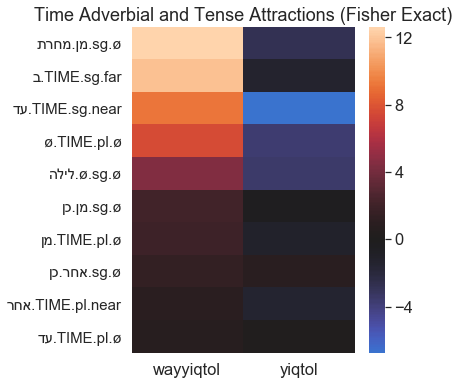

In [173]:
compare = cbt_assoc.loc[['wayq', 'impf']].T.sort_values(by='wayq', ascending=False).head(10)
compare.index = [prettytags[tag] for tag in compare.index]
compare.columns = [pretty_tense[tense] for tense in compare.columns]

plt.figure(figsize=(5, 6))
sns.heatmap(compare, center=0)
plt.yticks(size=15)
plt.savefig(firstyear+'heatmap_wayq_yiqt.png', dpi=300, bbox_inches='tight')
plt.title('Time Adverbial and Tense Attractions (Fisher Exact)')
plt.show()

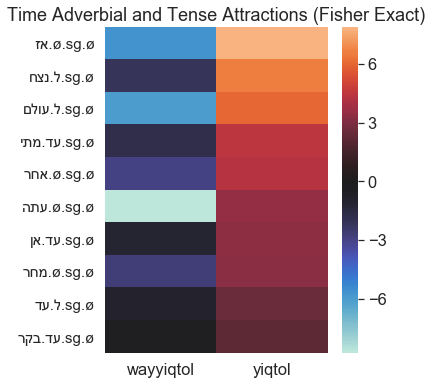

In [174]:
compare = cbt_assoc.loc[['wayq', 'impf']].T.sort_values(by='impf', ascending=False).head(10)
compare.index = [prettytags[tag] for tag in compare.index]
compare.columns = [pretty_tense[tense] for tense in compare.columns]

plt.figure(figsize=(5, 6))
sns.heatmap(compare, center=0)
plt.yticks(size=15)
plt.savefig(firstyear+'heatmap_yqtl_wyqt.png', dpi=300, bbox_inches='tight')
plt.title('Time Adverbial and Tense Attractions (Fisher Exact)')
plt.show()

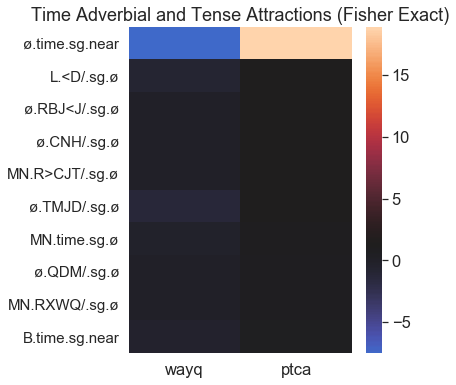

In [131]:
compare = cbt_assoc.loc[['wayq', 'ptca']].T.sort_values(by='ptca', ascending=False).head(10)

plt.figure(figsize=(5, 6))
plt.title('Time Adverbial and Tense Attractions (Fisher Exact)')
sns.heatmap(compare, center=1.3)
plt.yticks(size=15)
plt.show()

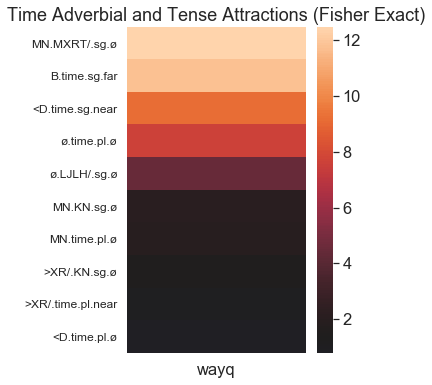

In [132]:
compare = cbt_assoc.loc[['wayq']].T.sort_values(by='wayq', ascending=False).head(10)

plt.figure(figsize=(4, 6))
plt.title('Time Adverbial and Tense Attractions (Fisher Exact)')
sns.heatmap(compare, center=1.3, robust=True)
plt.yticks(size=12)
plt.show()